In [0]:
import csv
import random
import time
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets

from random import shuffle
from collections import defaultdict
from copy import deepcopy
from itertools import chain


from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler


In [0]:
# The below code implements Optimizer class and is taken from pytorch's github implementation

required = object()


class Optimizer(object):
    """Base class for all optimizers.

    Arguments:
        params (iterable): an iterable of :class:`Variable` s or
            :class:`dict` s. Specifies what Variables should be optimized.
        defaults: (dict): a dict containing default values of optimization
            options (used when a parameter group doesn't specify them).
    """

    def __init__(self, params, defaults):
        self.defaults = defaults

        if isinstance(params, Variable) or torch.is_tensor(params):
            raise TypeError("params argument given to the optimizer should be "
                            "an iterable of Variables or dicts, but got " +
                            torch.typename(params))

        self.state = defaultdict(dict)
        self.param_groups = []

        param_groups = list(params)
        if len(param_groups) == 0:
            raise ValueError("optimizer got an empty parameter list")
        if not isinstance(param_groups[0], dict):
            param_groups = [{'params': param_groups}]

        for param_group in param_groups:
            self.add_param_group(param_group)

    def __getstate__(self):
        return {
            'state': self.state,
            'param_groups': self.param_groups,
        }

    def __setstate__(self, state):
        self.__dict__.update(state)

    def state_dict(self):
        """Returns the state of the optimizer as a :class:`dict`.

        It contains two entries:

        * state - a dict holding current optimization state. Its content
            differs between optimizer classes.
        * param_groups - a dict containing all parameter groups
        """
        # Save ids instead of Variables
        def pack_group(group):
            packed = {k: v for k, v in group.items() if k != 'params'}
            packed['params'] = [id(p) for p in group['params']]
            return packed
        param_groups = [pack_group(g) for g in self.param_groups]
        # Remap state to use ids as keys
        packed_state = {(id(k) if isinstance(k, Variable) else k): v
                        for k, v in self.state.items()}
        return {
            'state': packed_state,
            'param_groups': param_groups,
        }

    def load_state_dict(self, state_dict):
        """Loads the optimizer state.

        Arguments:
            state_dict (dict): optimizer state. Should be an object returned
                from a call to :meth:`state_dict`.
        """
        # deepcopy, to be consistent with module API
        state_dict = deepcopy(state_dict)
        # Validate the state_dict
        groups = self.param_groups
        saved_groups = state_dict['param_groups']

        if len(groups) != len(saved_groups):
            raise ValueError("loaded state dict has a different number of "
                             "parameter groups")
        param_lens = (len(g['params']) for g in groups)
        saved_lens = (len(g['params']) for g in saved_groups)
        if any(p_len != s_len for p_len, s_len in zip(param_lens, saved_lens)):
            raise ValueError("loaded state dict contains a parameter group "
                             "that doesn't match the size of optimizer's group")

        # Update the state
        id_map = {old_id: p for old_id, p in
                  zip(chain(*(g['params'] for g in saved_groups)),
                      chain(*(g['params'] for g in groups)))}
        state = defaultdict(
            dict, {id_map.get(k, k): v for k, v in state_dict['state'].items()})

        # Update parameter groups, setting their 'params' value
        def update_group(group, new_group):
            new_group['params'] = group['params']
            return new_group
        param_groups = [
            update_group(g, ng) for g, ng in zip(groups, saved_groups)]
        self.__setstate__({'state': state, 'param_groups': param_groups})

    def zero_grad(self):
        """Clears the gradients of all optimized :class:`Variable` s."""
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    if p.grad.volatile:
                        p.grad.data.zero_()
                    else:
                        data = p.grad.data
                        p.grad = Variable(data.new().resize_as_(data).zero_())

    def step(self, closure):
        """Performs a single optimization step (parameter update).

        Arguments:
            closure (callable): A closure that reevaluates the model and
                returns the loss. Optional for most optimizers.
        """
        raise NotImplementedError

    def add_param_group(self, param_group):
        """Add a param group to the :class:`Optimizer` s `param_groups`.

        This can be useful when fine tuning a pre-trained network as frozen layers can be made
        trainable and added to the :class:`Optimizer` as training progresses.

        Arguments:
            param_group (dict): Specifies what Variables should be optimized along with group
            specific optimization options.
        """
        assert isinstance(param_group, dict), "param group must be a dict"

        params = param_group['params']
        if isinstance(params, Variable):
            param_group['params'] = [params]
        else:
            param_group['params'] = list(params)

        for param in param_group['params']:
            if not isinstance(param, Variable):
                raise TypeError("optimizer can only optimize Variables, "
                                "but one of the params is " + torch.typename(param))
            if not param.requires_grad:
                raise ValueError("optimizing a parameter that doesn't require gradients")
            if not param.is_leaf:
                raise ValueError("can't optimize a non-leaf Variable")

        for name, default in self.defaults.items():
            if default is required and name not in param_group:
                raise ValueError("parameter group didn't specify a value of required optimization parameter " +
                                 name)
            else:
                param_group.setdefault(name, default)

        param_set = set()
        for group in self.param_groups:
            param_set.update(set(group['params']))

        if not param_set.isdisjoint(set(param_group['params'])):
            raise ValueError("some parameters appear in more than one parameter group")

        self.param_groups.append(param_group)


In [0]:
# The below code modifies pytorch implementation of Adams optimizer to implement Amsgrad algorithm 

class Amsgrad(Optimizer):
    """Implements Amsgrad algorithm.

    It has been proposed in `On the Convergence of Adam and Beyond`_.

    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)

    .. _n the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """

    # constructor to initialize the hyper-parameters
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.99), eps=1e-8,
                 weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay)
        super(Amsgrad, self).__init__(params, defaults)

    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Amsgrad does not support sparse gradients, please consider SparseAdam instead')

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    # Maximum exponential moving average of squared gradient values
                    state['exp_avg_sq_maximum'] = torch.zeros_like(p.data)
                exp_avg, exp_avg_sq, exp_avg_sq_maximum = state['exp_avg'], state['exp_avg_sq'], state['exp_avg_sq_maximum']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

               # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                
                # Calculate the maximum between the previous maximum exponential average of squared gradients and current value
                exp_avg_sq_maximum = torch.max(exp_avg_sq_maximum,exp_avg_sq)

                # Store the maximum
                state['exp_avg_sq_maximum'] = exp_avg_sq_maximum
                
                
                denom = exp_avg_sq_maximum.sqrt().add_(group['eps'])

               
                step_size = group['lr']
                
                
                # Performs update on parameters of the network based on gradients
                p.data.addcdiv_(-step_size, exp_avg, denom)

        return loss


In [5]:
'''
Reading CIFAR-10 dataset
'''

valid_size = 0.0
num_train_hyp = 5000
num_valid_hyp = 1000
batch_size = 128

# It converts the datapoints into tensor and then normalise each datapoint with given mean and standard deviation 
transform = transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize([0.5,], [0.5,])])

# Loading the  CIFAR-10 dataset consisting of 50000 colored training images and 10000 colored testing images of size 32 X 32 pixels in a batch size of 128 images at a time
# and performing the above transformations 
# Randomly splitting data into 5000 training examples and 1000 validation examples by generating 50000 random unique indices in the range [0,49999] and then retreiving the initial 5000 values at those indices for building the training dataset. The values at following 1000 indices are used for building validation dataset.
trainset_cifar_10 = datasets.CIFAR10('./', train=True, transform=transform, download=True)
num_train = len(trainset_cifar_10)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_idx_hyp, valid_idx_hyp = indices[num_valid_hyp:num_valid_hyp+num_train_hyp], indices[:num_valid_hyp]

train_sampler_cifar = SubsetRandomSampler(train_idx)
valid_sampler_cifar = SubsetRandomSampler(valid_idx)

train_sampler_cifar_hyp = SubsetRandomSampler(train_idx_hyp)
valid_sampler_cifar_hyp = SubsetRandomSampler(valid_idx_hyp)

trainloader_cifar_10 = torch.utils.data.DataLoader(trainset_cifar_10, batch_size=batch_size, sampler=train_sampler_cifar)
validloader_cifar_10 = torch.utils.data.DataLoader(trainset_cifar_10, batch_size=batch_size, sampler=valid_sampler_cifar)


trainloader_cifar_hyp = torch.utils.data.DataLoader(trainset_cifar_10, batch_size=batch_size, sampler=train_sampler_cifar_hyp)
validloader_cifar_hyp = torch.utils.data.DataLoader(trainset_cifar_10, batch_size=batch_size, sampler=valid_sampler_cifar_hyp)

testset_cifar_10 = torchvision.datasets.CIFAR10(root='./', train=False, download=True, transform=transform)
testloader_cifar_10 = torch.utils.data.DataLoader(testset_cifar_10, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
num_batches_train = int((1-valid_size)*num_train/batch_size)
num_batches_valid = int(valid_size*num_train/batch_size)
num_batches_train_hyp = int(num_train_hyp/batch_size)
num_batches_valid_hyp = int(num_valid_hyp/batch_size)
num_batches_test = int(len(testset_cifar_10)/batch_size)

In [7]:
num_batches_train, num_batches_valid, num_batches_train_hyp, num_batches_valid_hyp, num_batches_test

(390, 0, 39, 7, 78)

In [0]:
# Cifar architecture used in tensorflow
#1) 2 Conv layers with 64 output channels
#2) Size of filter for every conv layer is 5 in length and width and for Max-pooling layer, it is 2,2
#3) Padding is set to 2 with stride of 1
#4) 2 Fully connected layers with 384 and 192 units
#5) Batch normalization layers is done after first pool layer and 2nd conv layer
#6) Dropout is introduced to randomly turn on 50% of activation units in the FC-1 layer.
#7) The output layer gives raw scores for every class for every input.
#8) ReLU activation has been used to ensure that there is no Vanishing gradient issue


class CifarNet(nn.Module):
  
  def __init__(self):
    super(CifarNet, self).__init__()
    
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size=(5,5), stride=(1,1), padding=2)
    self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
    self.bn1 = nn.BatchNorm2d(64)
    
    self.conv2 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size=(5,5), stride=(1,1), padding=2)
    self.bn2 = nn.BatchNorm2d(64)
    
    self.fc1 = nn.Linear(64*8*8, 384)
    
    self.fc2 = nn.Linear(384, 192)

    self.fc3 = nn.Linear(192,10)
    
  def forward(self,x):
    
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = self.bn1(x)
    
    x = F.relu(self.conv2(x))
    x = self.bn2(x)
    x = self.pool(x)
    
    x = x.view(-1, 64*8*8)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, p=0.5)
    
    x = F.relu(self.fc2(x))

    x = self.fc3(x)
    return x

In [0]:
# Instanstiating the network on GPU
net = CifarNet()
initial_state = net.state_dict()
net = net.cuda()

In [10]:
print(net)

CifarNet(
  (conv1): Conv2d (3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (conv2): Conv2d (64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (fc1): Linear(in_features=4096, out_features=384)
  (fc2): Linear(in_features=384, out_features=192)
  (fc3): Linear(in_features=192, out_features=10)
)


In [0]:
# Learning the parameters using Amsgrad optimization with categorical cross-entropy loss.
criterion = nn.CrossEntropyLoss()
alphas = np.geomspace(1e-4,1e-6, num=7)
betas = [0.99, 0.992, 0.994, 0.995, 0.996, 0.998, 0.999]

In [12]:
alphas

array([1.00000000e-04, 4.64158883e-05, 2.15443469e-05, 1.00000000e-05,
       4.64158883e-06, 2.15443469e-06, 1.00000000e-06])

In [0]:
# The function validation_loss() calculates the loss on validation data which is shuffled and passed to the network in batch size of 128 instances after every epoch.
def validation_loss(validloader, num_batches_valid, net_, criterion_):
  running_valid_loss = 0.0
  for i, data in enumerate(validloader, 0):
      inputs, labels = data
      inputs = inputs.float()
      labels = labels.long()
      inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())


      valid_output = net_(inputs)
      loss_valid = criterion_(valid_output, labels)

      # print statistics
      running_valid_loss += loss_valid.data[0]
   
  return (running_valid_loss / num_batches_valid)

In [14]:
#Hyper-parameter tuning for AMSGrad for alpha and beta2 using trainig set of 5000 examples and validation set of 1000 examples for 15 epochs for a total of 49 hyper-parameter combinations

train_loss_list = []
valid_loss_list = []
for alpha in alphas:
  for beta in betas:
    train_loss_list.append(([], alpha, beta))
    valid_loss_list.append(([], alpha, beta))

num_epochs = 15
total_combo = len(alphas)*len(betas)

param_combo_count = 0
for alpha in alphas:
  for beta in betas:
    print("alpha:", alpha, " beta 2: ", beta)
    print("Parameter Combination:", param_combo_count+1, "/", total_combo)
    net.load_state_dict(initial_state)
    optimizer = Amsgrad(net.parameters(), lr=alpha, betas=(0.9,beta))
    start_time_combo = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss_train = 0.0
        for i, data in enumerate(trainloader_cifar_hyp, 0):
            # get the inputs
            inputs, labels = data

            # wrap them in Variable
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # print statistics
            running_loss_train += loss.data[0]
        
        train_loss = running_loss_train/num_batches_train_hyp
        valid_loss = validation_loss(validloader_cifar_hyp, num_batches_valid_hyp, net, criterion)
        print ('Epoch: %d Train loss: %.3f' %(epoch + 1, train_loss))
        print ('Epoch: %d Valid loss: %.3f' %(epoch + 1, valid_loss))
        train_loss_list[param_combo_count][0].append(train_loss)
        valid_loss_list[param_combo_count][0].append(valid_loss)

    elapsed_time = time.time() - start_time_combo
    print('Finished Training') 
    print("Time for 1 combination of hyper-parameters: ", elapsed_time)
    param_combo_count += 1
 

alpha: 0.0001  beta 2:  0.99
Parameter Combination: 1 / 49
Epoch: 1 Train loss: 1.918
Epoch: 1 Valid loss: 1.677
Epoch: 2 Train loss: 1.445
Epoch: 2 Valid loss: 1.383
Epoch: 3 Train loss: 1.249
Epoch: 3 Valid loss: 1.207
Epoch: 4 Train loss: 1.105
Epoch: 4 Valid loss: 1.115
Epoch: 5 Train loss: 0.996
Epoch: 5 Valid loss: 0.958
Epoch: 6 Train loss: 0.910
Epoch: 6 Valid loss: 0.836
Epoch: 7 Train loss: 0.799
Epoch: 7 Valid loss: 0.773
Epoch: 8 Train loss: 0.718
Epoch: 8 Valid loss: 0.683
Epoch: 9 Train loss: 0.618
Epoch: 9 Valid loss: 0.588
Epoch: 10 Train loss: 0.550
Epoch: 10 Valid loss: 0.503
Epoch: 11 Train loss: 0.477
Epoch: 11 Valid loss: 0.429
Epoch: 12 Train loss: 0.428
Epoch: 12 Valid loss: 0.385
Epoch: 13 Train loss: 0.362
Epoch: 13 Valid loss: 0.317
Epoch: 14 Train loss: 0.307
Epoch: 14 Valid loss: 0.266
Epoch: 15 Train loss: 0.246
Epoch: 15 Valid loss: 0.208
Finished Training
Time for 1 combination of hyper-parameters:  44.30512523651123
alpha: 0.0001  beta 2:  0.992
Paramete

Epoch: 15 Train loss: 0.602
Epoch: 15 Valid loss: 0.606
Finished Training
Time for 1 combination of hyper-parameters:  41.8095920085907
alpha: 4.641588833612782e-05  beta 2:  0.996
Parameter Combination: 12 / 49
Epoch: 1 Train loss: 2.000
Epoch: 1 Valid loss: 1.780
Epoch: 2 Train loss: 1.538
Epoch: 2 Valid loss: 1.510
Epoch: 3 Train loss: 1.363
Epoch: 3 Valid loss: 1.359
Epoch: 4 Train loss: 1.237
Epoch: 4 Valid loss: 1.245
Epoch: 5 Train loss: 1.146
Epoch: 5 Valid loss: 1.146
Epoch: 6 Train loss: 1.054
Epoch: 6 Valid loss: 1.080
Epoch: 7 Train loss: 0.994
Epoch: 7 Valid loss: 0.983
Epoch: 8 Train loss: 0.922
Epoch: 8 Valid loss: 0.926
Epoch: 9 Train loss: 0.861
Epoch: 9 Valid loss: 0.859
Epoch: 10 Train loss: 0.792
Epoch: 10 Valid loss: 0.805
Epoch: 11 Train loss: 0.751
Epoch: 11 Valid loss: 0.755
Epoch: 12 Train loss: 0.714
Epoch: 12 Valid loss: 0.691
Epoch: 13 Train loss: 0.650
Epoch: 13 Valid loss: 0.633
Epoch: 14 Train loss: 0.609
Epoch: 14 Valid loss: 0.590
Epoch: 15 Train loss: 

Epoch: 12 Train loss: 1.549
Epoch: 12 Valid loss: 1.674
Epoch: 13 Train loss: 1.522
Epoch: 13 Valid loss: 1.642
Epoch: 14 Train loss: 1.490
Epoch: 14 Valid loss: 1.612
Epoch: 15 Train loss: 1.466
Epoch: 15 Valid loss: 1.583
Finished Training
Time for 1 combination of hyper-parameters:  42.013671875
alpha: 1e-05  beta 2:  0.992
Parameter Combination: 23 / 49
Epoch: 1 Train loss: 2.305
Epoch: 1 Valid loss: 2.486
Epoch: 2 Train loss: 2.170
Epoch: 2 Valid loss: 2.331
Epoch: 3 Train loss: 2.034
Epoch: 3 Valid loss: 2.190
Epoch: 4 Train loss: 1.935
Epoch: 4 Valid loss: 2.070
Epoch: 5 Train loss: 1.834
Epoch: 5 Valid loss: 1.980
Epoch: 6 Train loss: 1.764
Epoch: 6 Valid loss: 1.904
Epoch: 7 Train loss: 1.716
Epoch: 7 Valid loss: 1.842
Epoch: 8 Train loss: 1.671
Epoch: 8 Valid loss: 1.794
Epoch: 9 Train loss: 1.619
Epoch: 9 Valid loss: 1.747
Epoch: 10 Train loss: 1.580
Epoch: 10 Valid loss: 1.704
Epoch: 11 Train loss: 1.546
Epoch: 11 Valid loss: 1.671
Epoch: 12 Train loss: 1.509
Epoch: 12 Vali

Epoch: 12 Train loss: 1.753
Epoch: 12 Valid loss: 1.909
Epoch: 13 Train loss: 1.732
Epoch: 13 Valid loss: 1.883
Epoch: 14 Train loss: 1.710
Epoch: 14 Valid loss: 1.851
Epoch: 15 Train loss: 1.686
Epoch: 15 Valid loss: 1.827
Finished Training
Time for 1 combination of hyper-parameters:  42.19466304779053
alpha: 4.641588833612782e-06  beta 2:  0.998
Parameter Combination: 34 / 49
Epoch: 1 Train loss: 2.313
Epoch: 1 Valid loss: 2.502
Epoch: 2 Train loss: 2.193
Epoch: 2 Valid loss: 2.375
Epoch: 3 Train loss: 2.082
Epoch: 3 Valid loss: 2.252
Epoch: 4 Train loss: 1.995
Epoch: 4 Valid loss: 2.156
Epoch: 5 Train loss: 1.917
Epoch: 5 Valid loss: 2.072
Epoch: 6 Train loss: 1.850
Epoch: 6 Valid loss: 2.005
Epoch: 7 Train loss: 1.802
Epoch: 7 Valid loss: 1.952
Epoch: 8 Train loss: 1.760
Epoch: 8 Valid loss: 1.910
Epoch: 9 Train loss: 1.714
Epoch: 9 Valid loss: 1.868
Epoch: 10 Train loss: 1.689
Epoch: 10 Valid loss: 1.830
Epoch: 11 Train loss: 1.663
Epoch: 11 Valid loss: 1.803
Epoch: 12 Train loss:

Epoch: 12 Train loss: 2.281
Epoch: 12 Valid loss: 2.541
Epoch: 13 Train loss: 2.274
Epoch: 13 Valid loss: 2.534
Epoch: 14 Train loss: 2.263
Epoch: 14 Valid loss: 2.527
Epoch: 15 Train loss: 2.256
Epoch: 15 Valid loss: 2.520
Finished Training
Time for 1 combination of hyper-parameters:  42.105908155441284
alpha: 1e-06  beta 2:  0.994
Parameter Combination: 45 / 49
Epoch: 1 Train loss: 2.359
Epoch: 1 Valid loss: 2.624
Epoch: 2 Train loss: 2.343
Epoch: 2 Valid loss: 2.611
Epoch: 3 Train loss: 2.333
Epoch: 3 Valid loss: 2.602
Epoch: 4 Train loss: 2.327
Epoch: 4 Valid loss: 2.593
Epoch: 5 Train loss: 2.318
Epoch: 5 Valid loss: 2.585
Epoch: 6 Train loss: 2.312
Epoch: 6 Valid loss: 2.577
Epoch: 7 Train loss: 2.302
Epoch: 7 Valid loss: 2.569
Epoch: 8 Train loss: 2.297
Epoch: 8 Valid loss: 2.562
Epoch: 9 Train loss: 2.289
Epoch: 9 Valid loss: 2.553
Epoch: 10 Train loss: 2.283
Epoch: 10 Valid loss: 2.546
Epoch: 11 Train loss: 2.277
Epoch: 11 Valid loss: 2.537
Epoch: 12 Train loss: 2.268
Epoch: 1

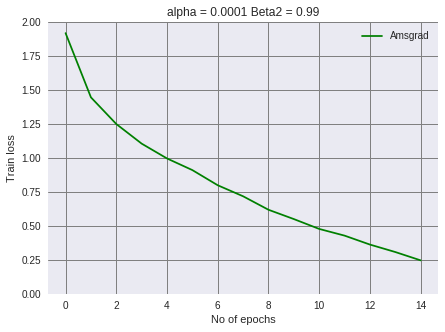

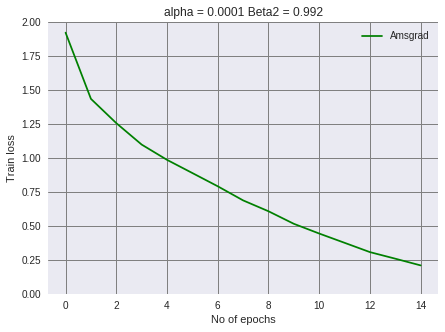

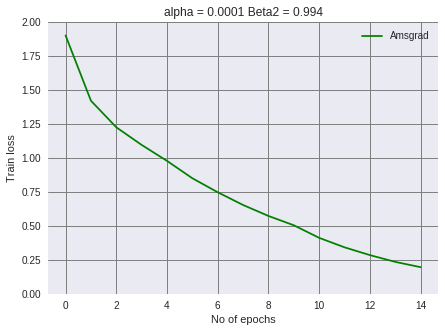

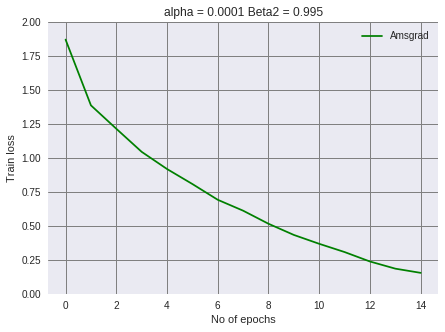

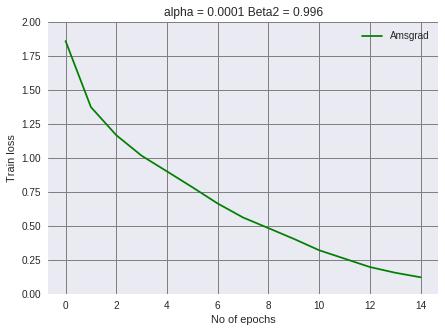

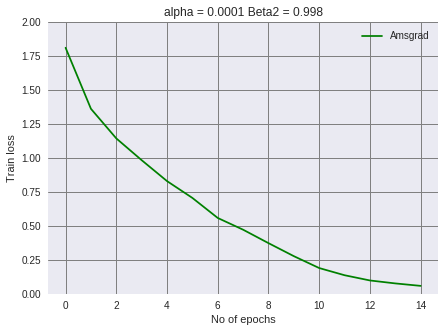

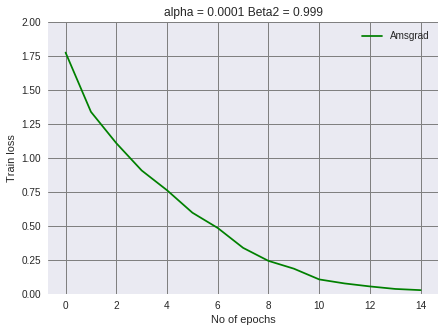

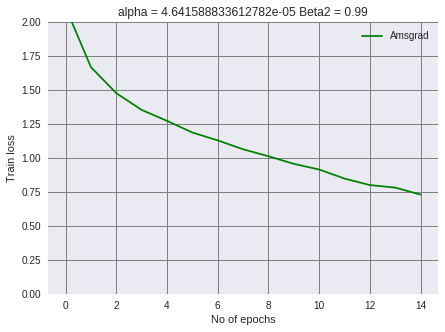

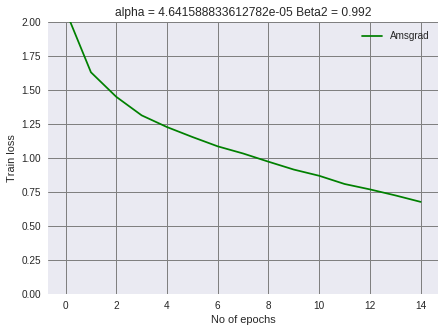

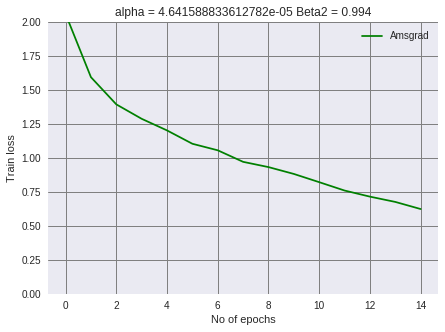

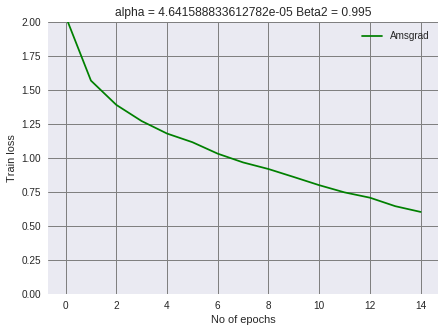

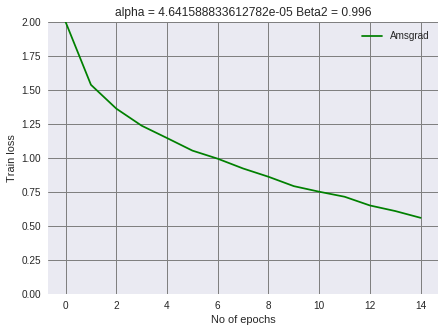

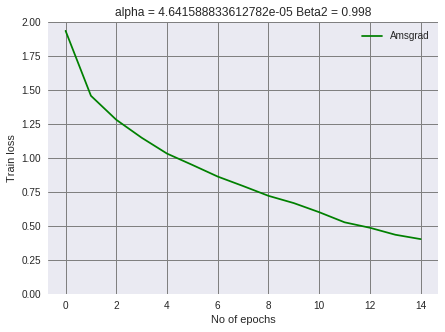

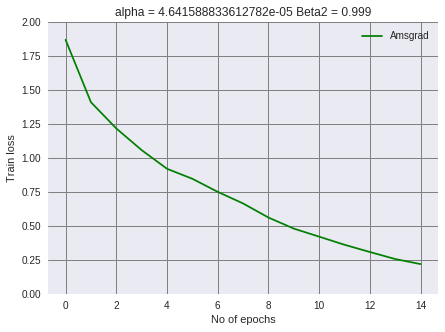

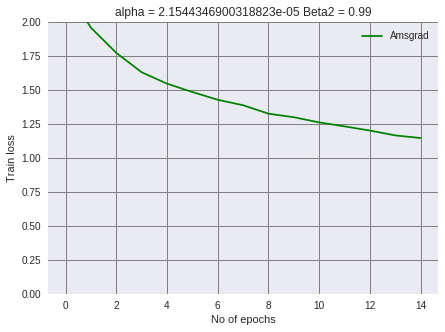

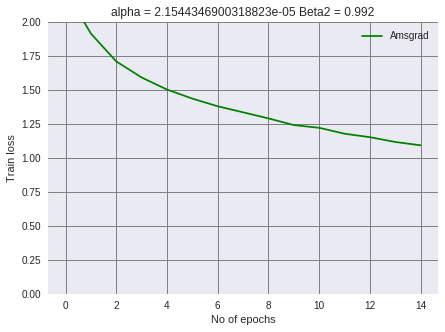

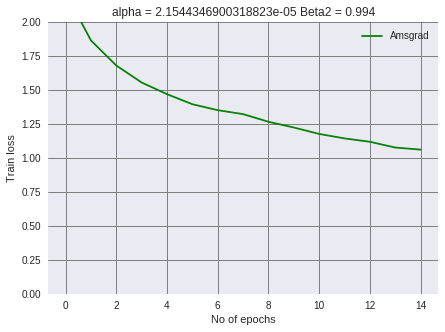

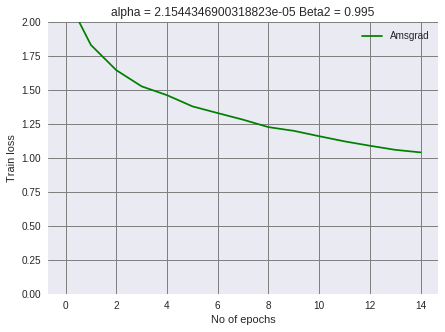

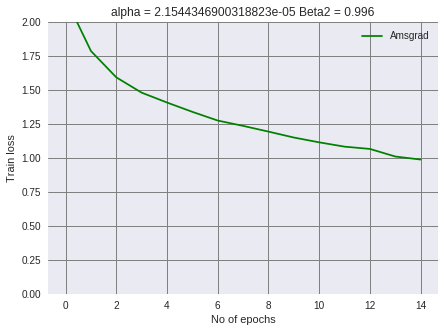

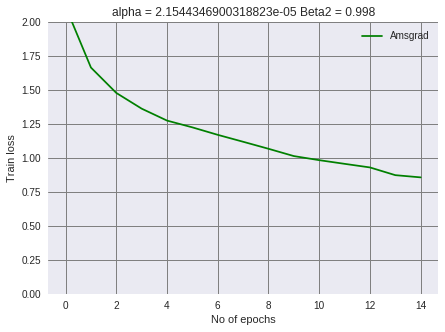

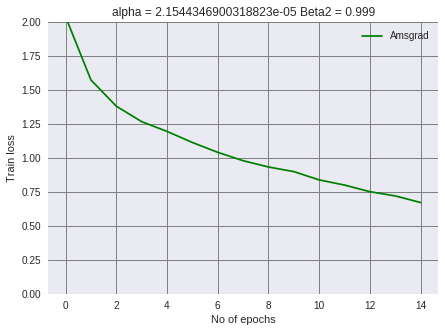

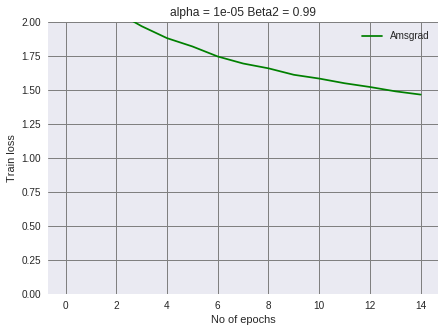

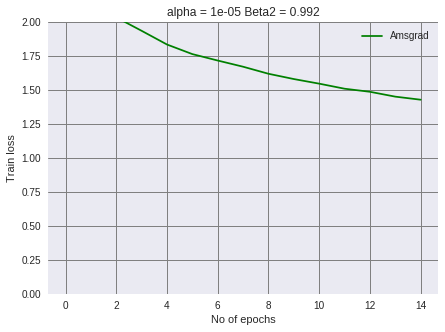

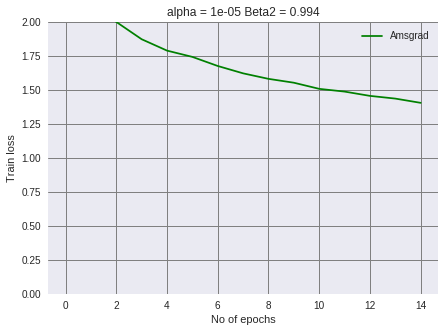

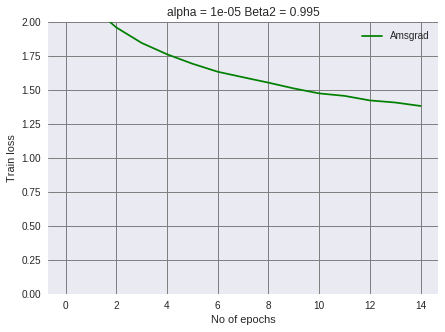

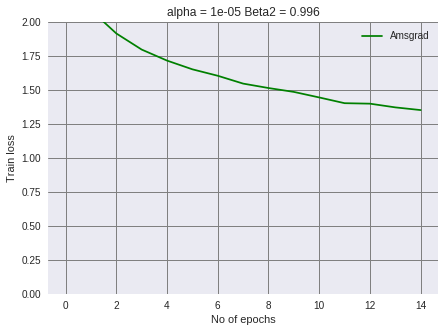

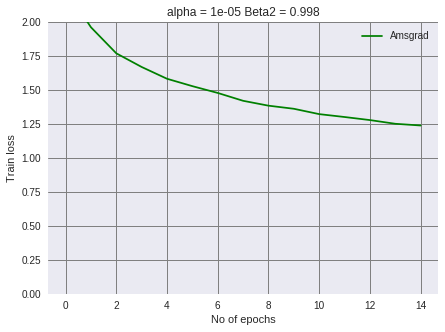

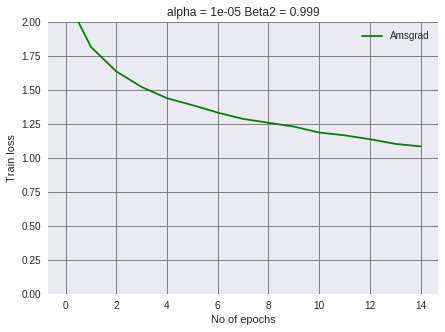

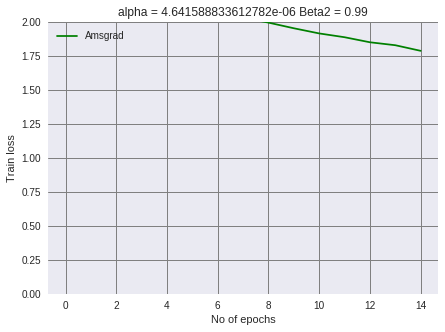

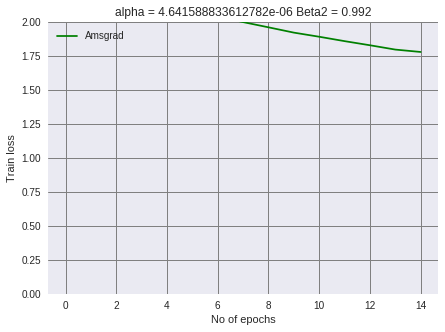

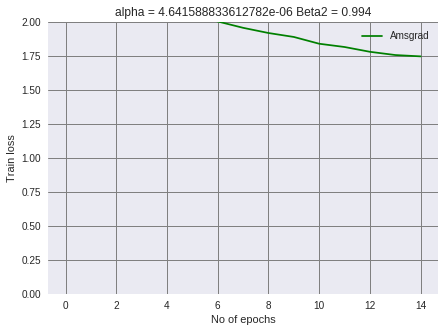

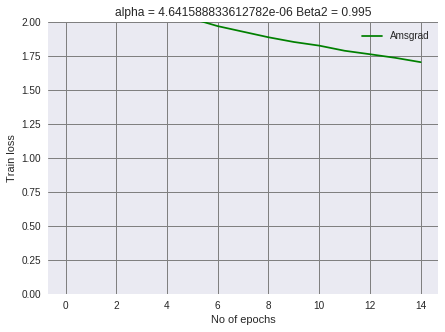

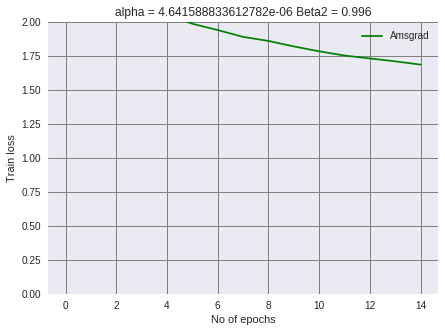

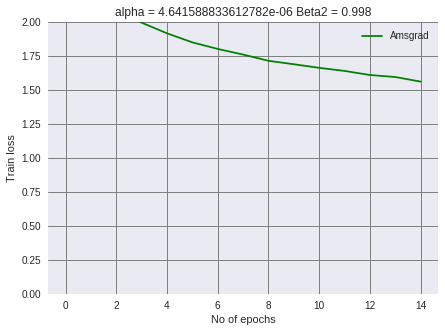

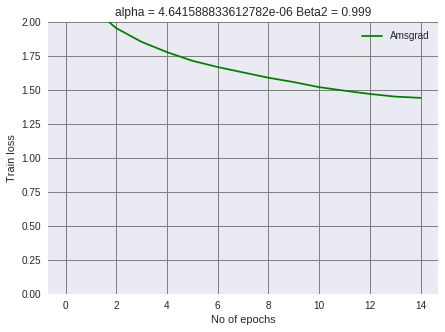

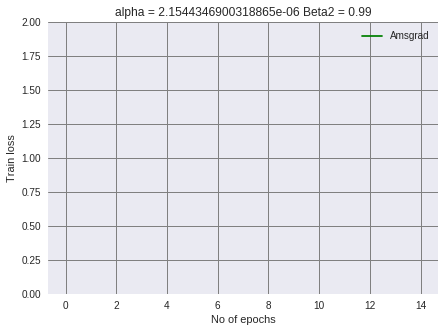

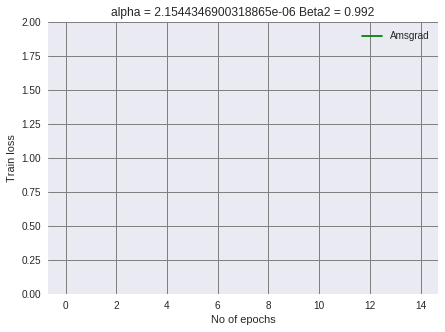

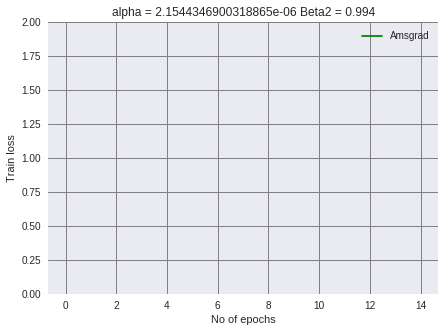

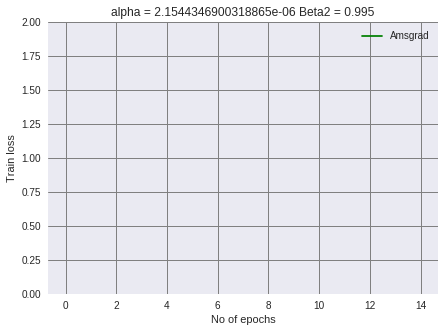

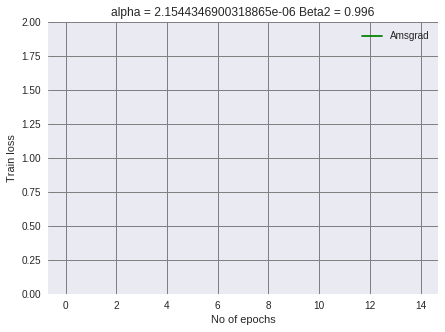

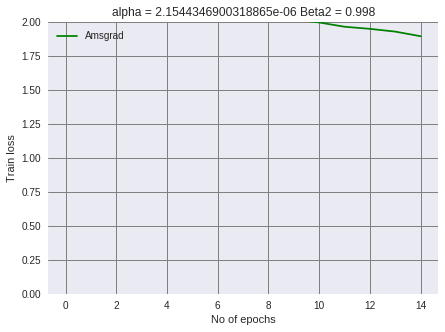

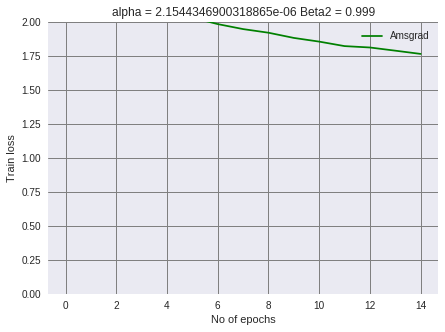

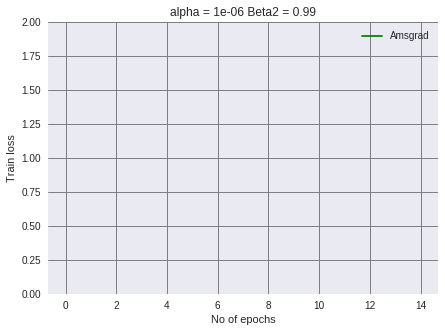

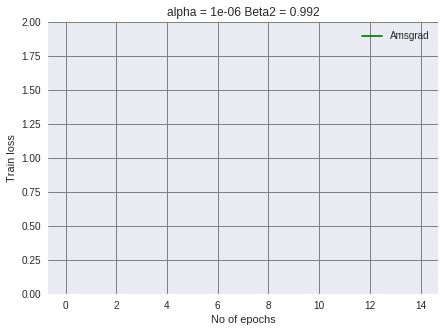

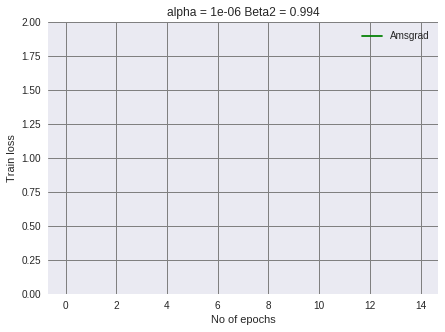

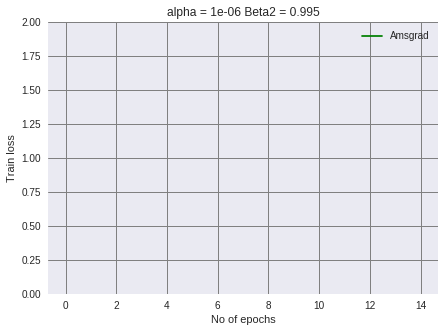

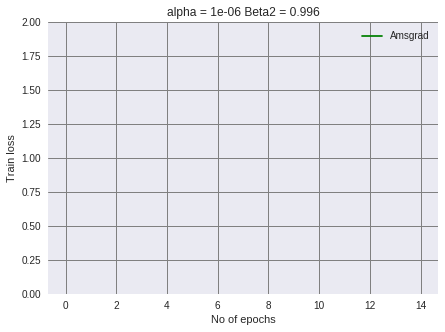

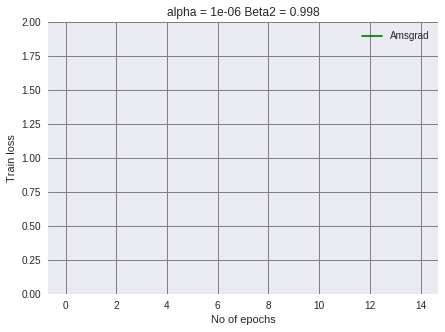

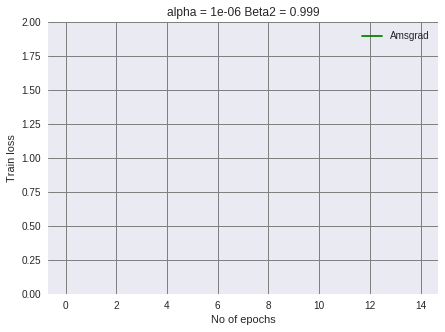

In [15]:
#Plotting train loss vs number of iterations graph for every hyper-parameter combination for AMSGrad

x = np.arange(0,num_epochs)
for i in range(len(train_loss_list)):
  
  plt.figure(figsize=(7,5))
  title = "alpha = " + str(train_loss_list[i][1]) + " Beta2 = " + str(train_loss_list[i][2])
  plt.title(title)
  plt.plot(x, train_loss_list[i][0], 'g', label="Amsgrad")
  plt.ylim(0,2)
  plt.grid(color='gray', linewidth=1)
  plt.legend(loc='best')
  plt.xlabel('No of epochs')
  plt.ylabel('Train loss')
  plt.show()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


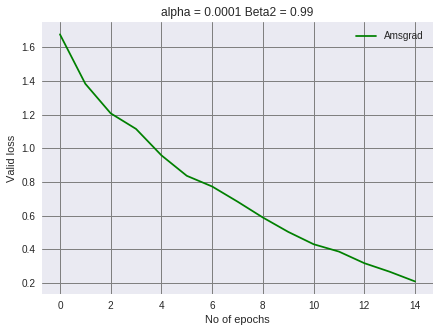

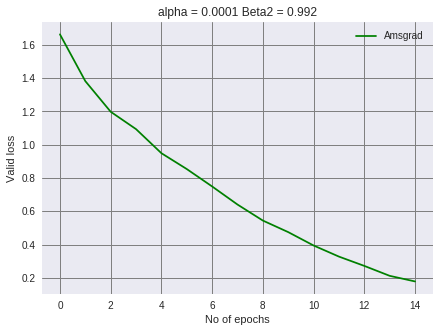

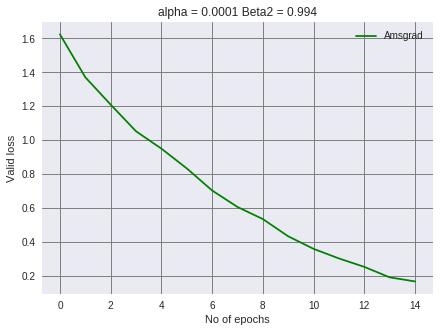

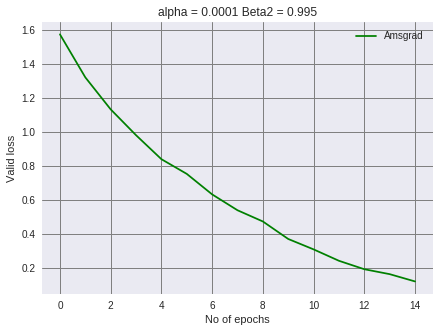

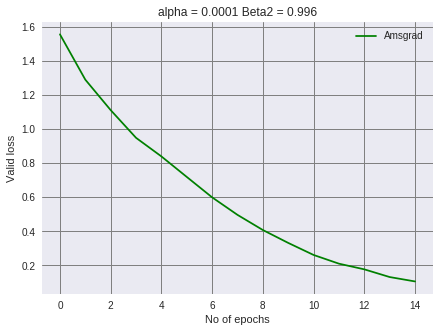

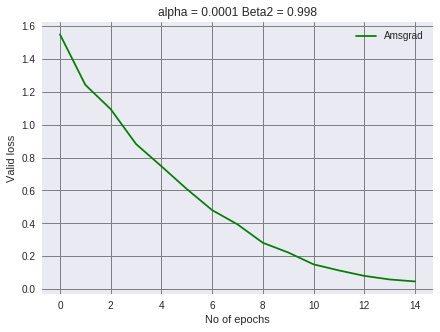

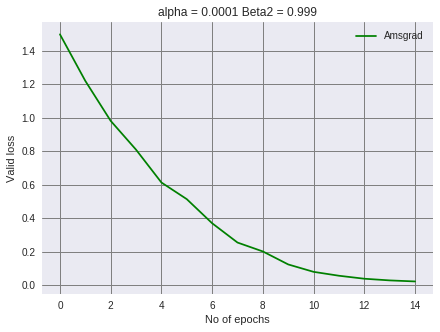

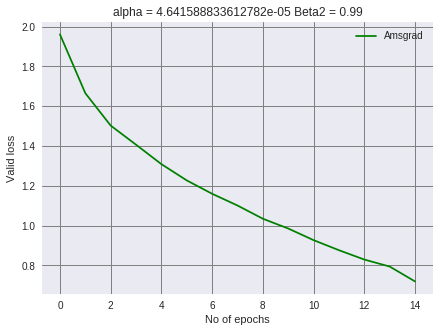

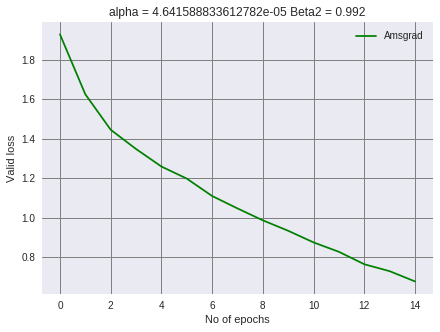

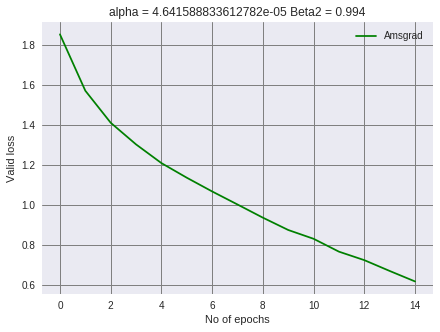

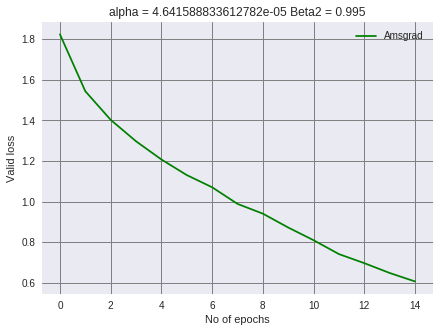

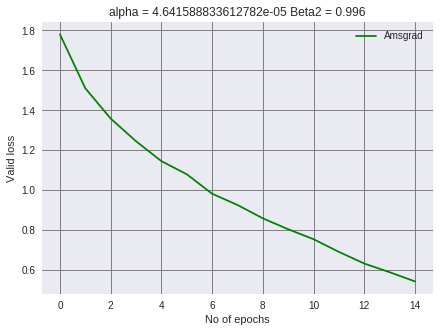

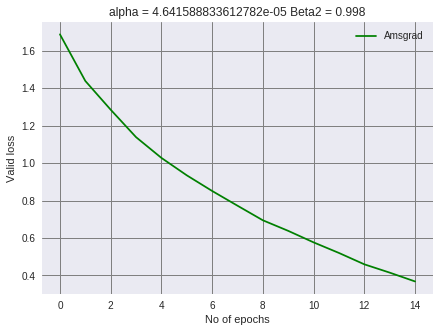

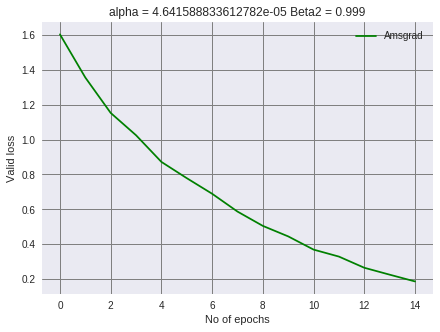

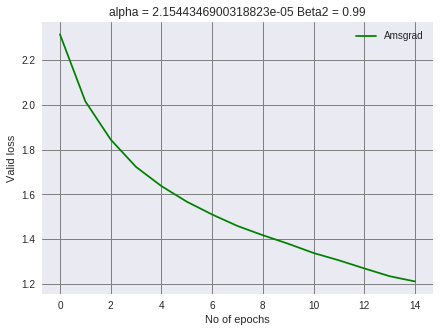

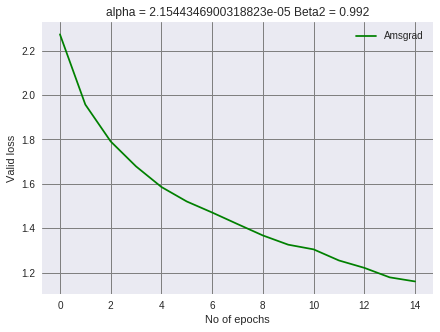

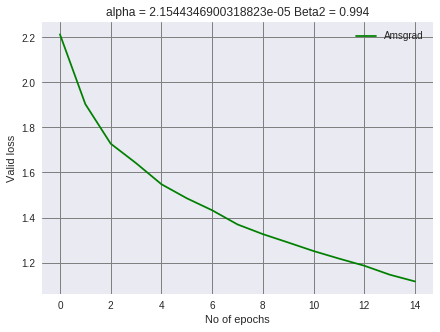

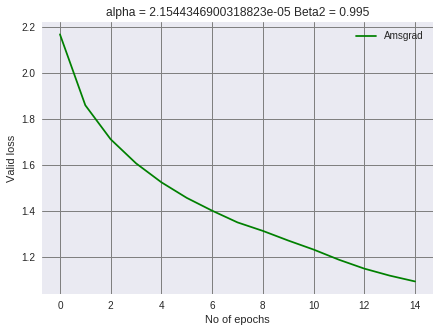

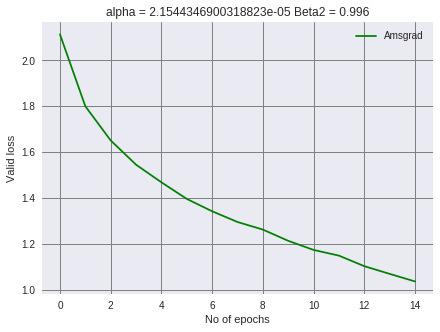

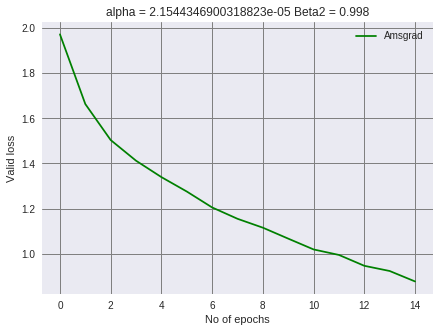

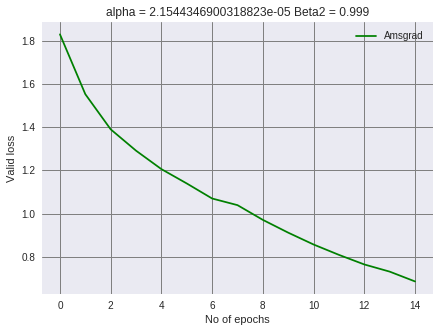

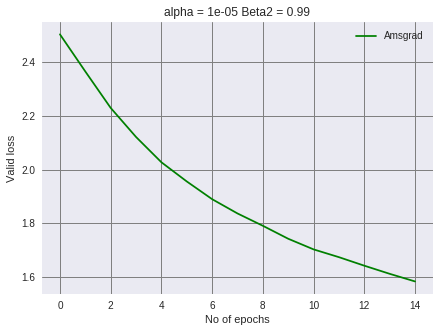

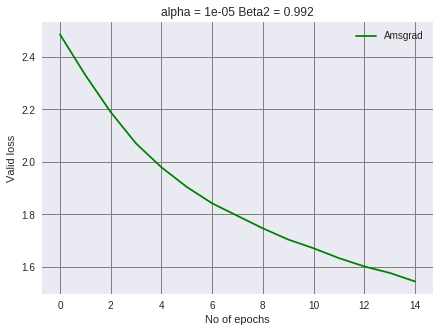

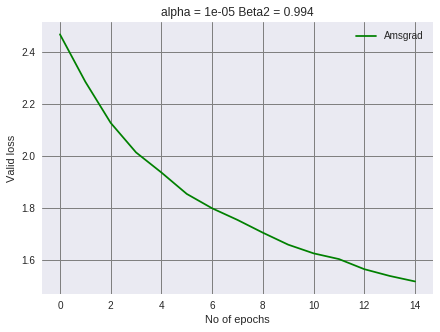

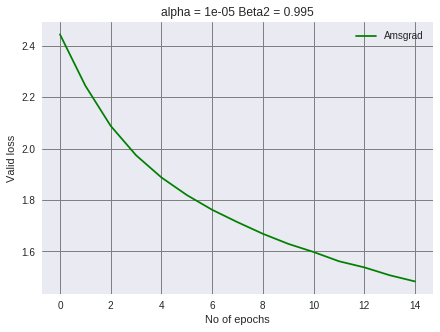

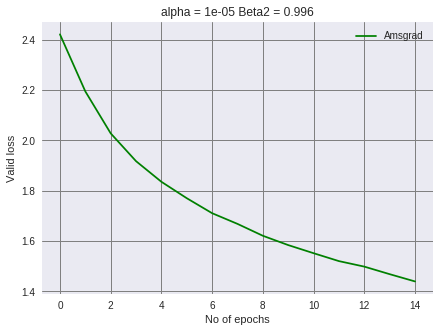

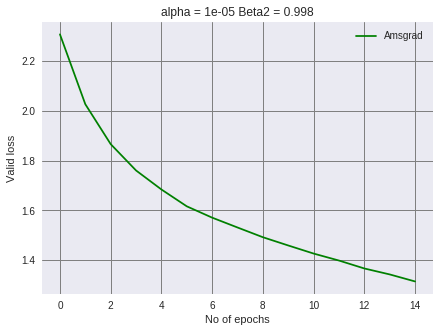

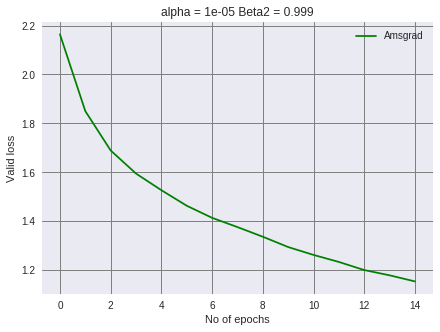

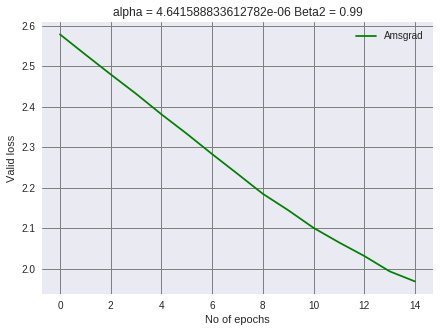

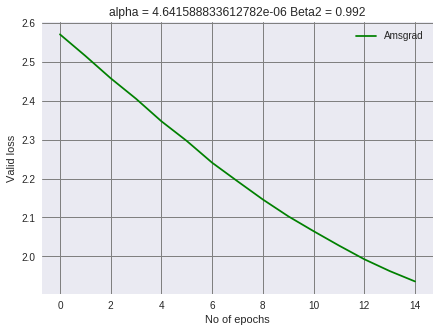

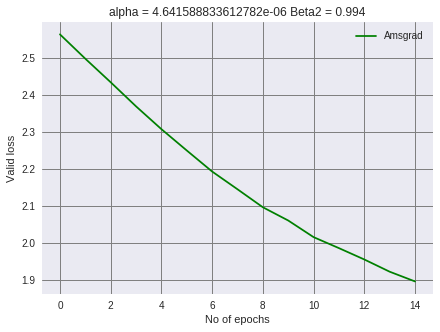

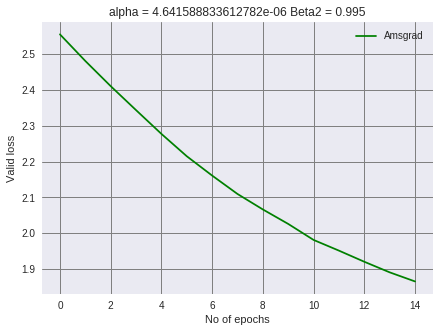

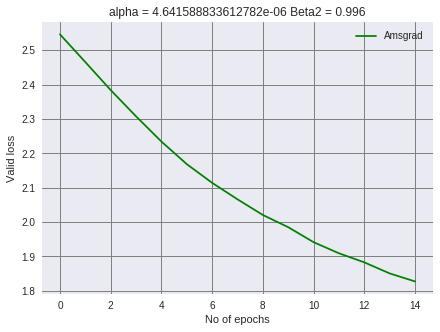

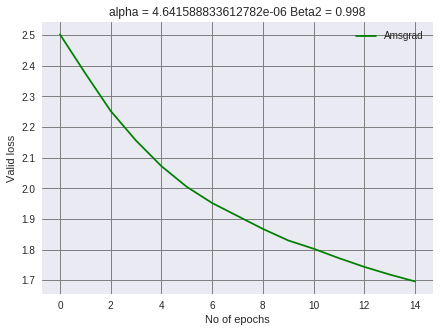

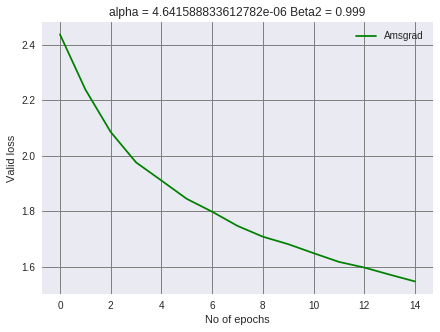

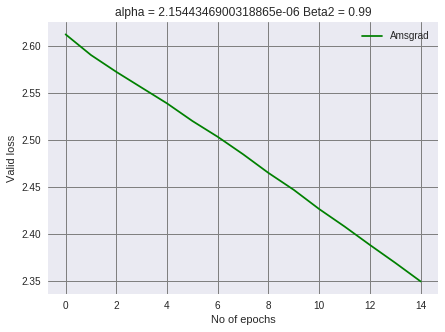

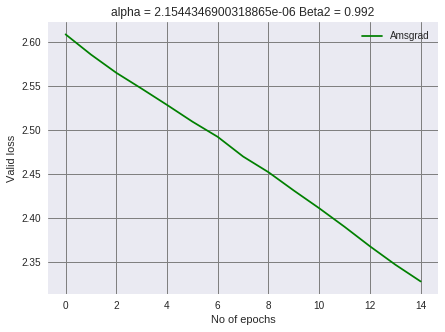

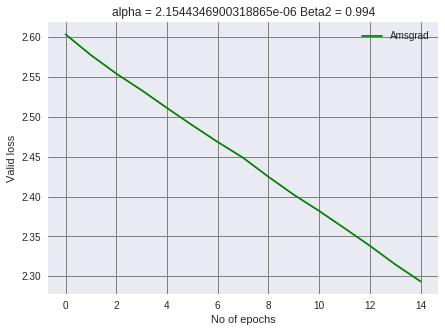

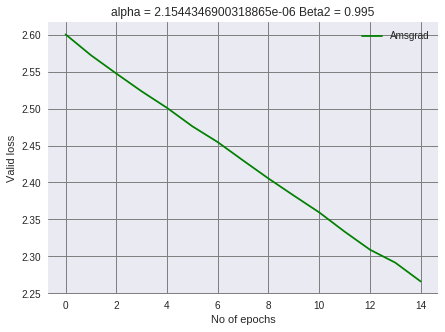

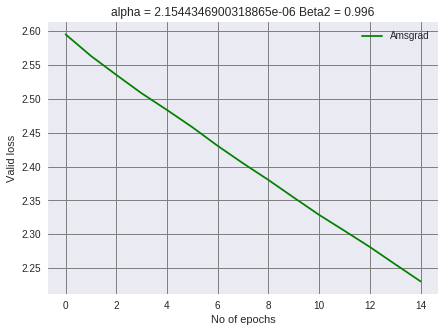

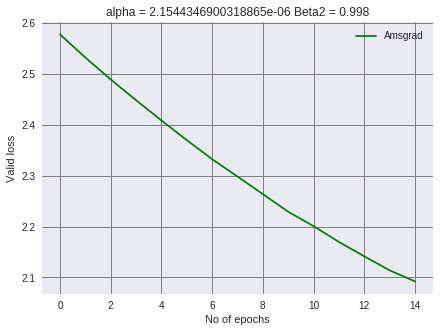

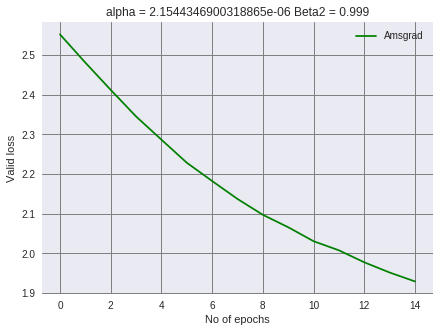

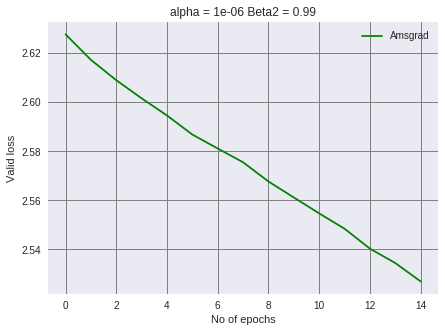

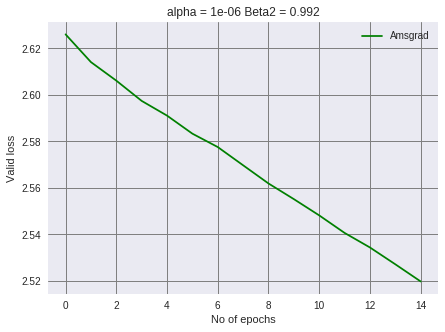

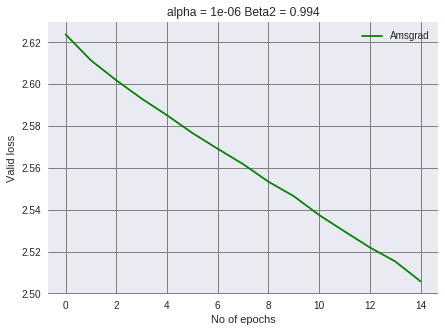

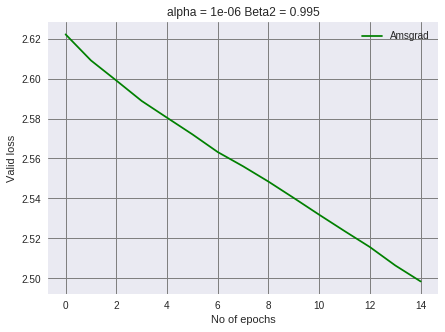

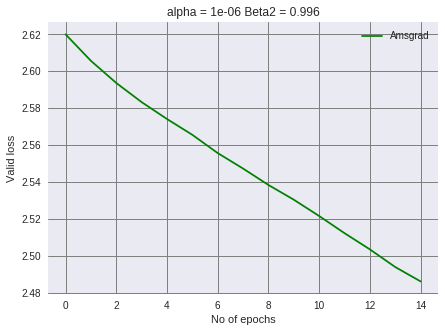

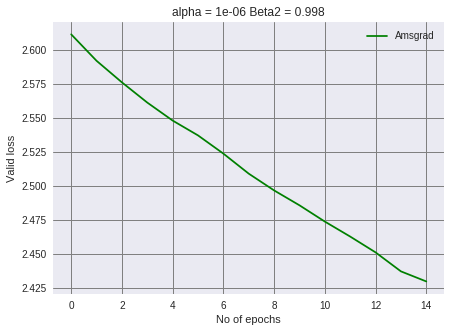

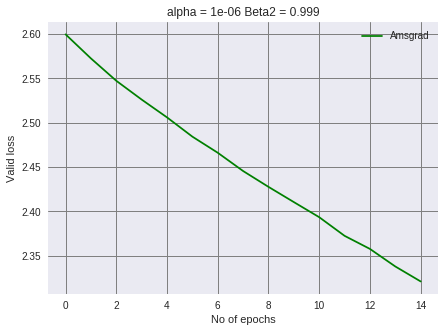

In [16]:
#Plotting validation loss vs number of iterations graph for every hyper-parameter combination for AMSGrad
x = np.arange(0,num_epochs)
print(x)
for i in range(len(valid_loss_list)):
  
  plt.figure(figsize=(7,5))
  title = "alpha = " + str(valid_loss_list[i][1]) + " Beta2 = " + str(valid_loss_list[i][2])
  plt.title(title)
  plt.plot(x, valid_loss_list[i][0], 'g', label="Amsgrad")
  plt.grid(color='gray', linewidth=1)
  plt.legend(loc='best')
  plt.xlabel('No of epochs')
  plt.ylabel('Valid loss')
  plt.show()

In [0]:
#Minimum validation loss was calculated for eachcombination  and  the  pair  which  resulted  in  least  validationloss with a non-increasing trajectory of validation loss withepochs was chosen as the best value for the hyper-parameters
min_valid_loss = []
param_combo_count = 0   
for alpha_idx, alpha in enumerate(alphas):
  for beta_idx, beta in enumerate(betas):
    min_valid_for_alpha_beta = (min(valid_loss_list[param_combo_count][0]))
    min_valid_loss.append(min_valid_for_alpha_beta)
    param_combo_count += 1

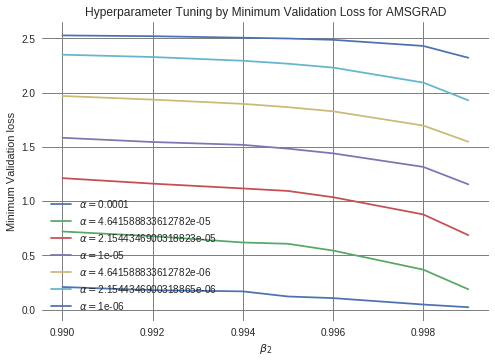

In [18]:
# Hyperparameter Tuning results by Minimum Validation Loss for AMSGRAD

count = 0
title = "Hyperparameter Tuning by Minimum Validation Loss for AMSGRAD"
plt.title(title)
for i , alpha in enumerate(alphas):
  plt.plot(betas, min_valid_loss[count:count+len(betas)], label=r'$\alpha = $'+str(alpha))
  count += len(betas)
plt.gca().set_facecolor('w')
plt.grid(color='gray', linewidth=1)
plt.legend(loc='best')
#plt.ylim(0,2.7)
plt.xlabel(r'$\beta_2$')
plt.ylabel('Minimum Validation loss')
plt.show()

In [0]:
alpha_amsgrad = 2.15443469e-05
beta2_amsgrad = 0.999

In [0]:
# Instanstiating the network on GPU

net.load_state_dict(initial_state)

In [0]:
# Learning the parameters using Amsgrad optimization with categorical cross-entropy loss. The learning rate is initially set to 0.001.
optimizer = Amsgrad(net.parameters(), lr=alpha_amsgrad, betas=(0.9,beta2_amsgrad))

In [36]:
#The code below runs for 70 epochs, learns the parameters of the model using Amsgrad optimizer with cross-entropy loss function 
#and propagates back the gradients in the network. It prints the train loss after every epoch and validation loss after each epoch.
train_loss_list_epoch = []
test_loss_list_epoch = []
train_loss_list_iter = []
pkl_filename = 'nn_saved_model.pkl'
num_epochs = 70
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss_train = 0.0
    
    for i, data in enumerate(trainloader_cifar_10, 0):
        running_loss = 0.0
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss_train += loss.data[0]
        running_loss = loss.data[0]
        train_loss_list_iter.append(running_loss)
    train_loss = running_loss_train/num_batches_train
    test_loss = validation_loss(testloader_cifar_10, num_batches_test, net, criterion)
    print ('Epoch: %d Train loss: %.3f' %(epoch + 1, train_loss))
    print ('Epoch: %d Test loss: %.3f' %(epoch + 1, test_loss))
    train_loss_list_epoch.append(train_loss)
    test_loss_list_epoch.append(test_loss)

    torch.save(net.state_dict(), pkl_filename)

print('Finished Training')

Epoch: 1 Train loss: 1.402
Epoch: 1 Test loss: 1.195
Epoch: 2 Train loss: 1.095
Epoch: 2 Test loss: 1.086
Epoch: 3 Train loss: 0.983
Epoch: 3 Test loss: 1.017
Epoch: 4 Train loss: 0.908
Epoch: 4 Test loss: 0.979
Epoch: 5 Train loss: 0.850
Epoch: 5 Test loss: 0.954
Epoch: 6 Train loss: 0.802
Epoch: 6 Test loss: 0.923
Epoch: 7 Train loss: 0.758
Epoch: 7 Test loss: 0.908
Epoch: 8 Train loss: 0.717
Epoch: 8 Test loss: 0.895
Epoch: 9 Train loss: 0.680
Epoch: 9 Test loss: 0.881
Epoch: 10 Train loss: 0.644
Epoch: 10 Test loss: 0.872
Epoch: 11 Train loss: 0.611
Epoch: 11 Test loss: 0.868
Epoch: 12 Train loss: 0.580
Epoch: 12 Test loss: 0.871
Epoch: 13 Train loss: 0.548
Epoch: 13 Test loss: 0.875
Epoch: 14 Train loss: 0.518
Epoch: 14 Test loss: 0.869
Epoch: 15 Train loss: 0.488
Epoch: 15 Test loss: 0.881
Epoch: 16 Train loss: 0.460
Epoch: 16 Test loss: 0.880
Epoch: 17 Train loss: 0.434
Epoch: 17 Test loss: 0.883
Epoch: 18 Train loss: 0.408
Epoch: 18 Test loss: 0.890
Epoch: 19 Train loss: 0.381


In [0]:
# Instanstiating the network on GPU
net_adam = CifarNet()
net_adam.load_state_dict(initial_state)
net_adam = net_adam.cuda()

In [20]:
#Hyper-parameter tuning for Adam for alpha and beta2 using trainig set of 5000 examples and validation set of 1000 examples for 15 epochs for a total of 49 hyper-parameter combinations



train_loss_list_adam = []
valid_loss_list_adam = []
for alpha in alphas:
  for beta in betas:
    train_loss_list_adam.append(([], alpha, beta))
    valid_loss_list_adam.append(([], alpha, beta))

num_epochs = 15
total_combo = len(alphas)*len(betas)

param_combo_count = 0
for alpha in alphas:
  for beta in betas:
    print("alpha:", alpha, " beta 2: ", beta)
    print("Parameter Combination:", param_combo_count+1, "/", total_combo)
    net_adam.load_state_dict(initial_state)
    optimizer_adam = optim.Adam(net_adam.parameters(), lr=alpha, betas=(0.9,beta))
    start_time_combo = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss_train = 0.0
        for i, data in enumerate(trainloader_cifar_hyp, 0):
            # get the inputs
            inputs, labels = data

            # wrap them in Variable
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

            # zero the parameter gradients
            optimizer_adam.zero_grad()

            # forward + backward + optimize
            outputs = net_adam(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer_adam.step()
            
            # print statistics
            running_loss_train += loss.data[0]
        
        train_loss = running_loss_train/num_batches_train_hyp
        valid_loss = validation_loss(validloader_cifar_hyp, num_batches_valid_hyp,net_adam, criterion)
        print ('Epoch: %d Train loss: %.3f' %(epoch + 1, train_loss))
        print ('Epoch: %d Valid loss: %.3f' %(epoch + 1, valid_loss))
        train_loss_list_adam[param_combo_count][0].append(train_loss)
        valid_loss_list_adam[param_combo_count][0].append(valid_loss)

    elapsed_time = time.time() - start_time_combo
    print('Finished Training') 
    print("Time for 1 combination of hyper-parameters: ", elapsed_time)
    param_combo_count += 1


alpha: 0.0001  beta 2:  0.99
Parameter Combination: 1 / 49
Epoch: 1 Train loss: 2.077
Epoch: 1 Valid loss: 1.881
Epoch: 2 Train loss: 1.610
Epoch: 2 Valid loss: 1.547
Epoch: 3 Train loss: 1.392
Epoch: 3 Valid loss: 1.381
Epoch: 4 Train loss: 1.227
Epoch: 4 Valid loss: 1.238
Epoch: 5 Train loss: 1.116
Epoch: 5 Valid loss: 1.133
Epoch: 6 Train loss: 1.004
Epoch: 6 Valid loss: 0.979
Epoch: 7 Train loss: 0.902
Epoch: 7 Valid loss: 0.886
Epoch: 8 Train loss: 0.815
Epoch: 8 Valid loss: 0.794
Epoch: 9 Train loss: 0.711
Epoch: 9 Valid loss: 0.665
Epoch: 10 Train loss: 0.620
Epoch: 10 Valid loss: 0.596
Epoch: 11 Train loss: 0.528
Epoch: 11 Valid loss: 0.495
Epoch: 12 Train loss: 0.457
Epoch: 12 Valid loss: 0.432
Epoch: 13 Train loss: 0.396
Epoch: 13 Valid loss: 0.319
Epoch: 14 Train loss: 0.311
Epoch: 14 Valid loss: 0.268
Epoch: 15 Train loss: 0.258
Epoch: 15 Valid loss: 0.210
Finished Training
Time for 1 combination of hyper-parameters:  42.65007019042969
alpha: 0.0001  beta 2:  0.992
Paramete

Epoch: 15 Train loss: 0.733
Epoch: 15 Valid loss: 0.739
Finished Training
Time for 1 combination of hyper-parameters:  42.881229877471924
alpha: 4.641588833612782e-05  beta 2:  0.996
Parameter Combination: 12 / 49
Epoch: 1 Train loss: 2.234
Epoch: 1 Valid loss: 2.264
Epoch: 2 Train loss: 1.876
Epoch: 2 Valid loss: 1.884
Epoch: 3 Train loss: 1.639
Epoch: 3 Valid loss: 1.665
Epoch: 4 Train loss: 1.482
Epoch: 4 Valid loss: 1.516
Epoch: 5 Train loss: 1.373
Epoch: 5 Valid loss: 1.418
Epoch: 6 Train loss: 1.285
Epoch: 6 Valid loss: 1.311
Epoch: 7 Train loss: 1.188
Epoch: 7 Valid loss: 1.250
Epoch: 8 Train loss: 1.143
Epoch: 8 Valid loss: 1.173
Epoch: 9 Train loss: 1.070
Epoch: 9 Valid loss: 1.107
Epoch: 10 Train loss: 1.012
Epoch: 10 Valid loss: 1.016
Epoch: 11 Train loss: 0.961
Epoch: 11 Valid loss: 0.968
Epoch: 12 Train loss: 0.891
Epoch: 12 Valid loss: 0.925
Epoch: 13 Train loss: 0.850
Epoch: 13 Valid loss: 0.846
Epoch: 14 Train loss: 0.787
Epoch: 14 Valid loss: 0.795
Epoch: 15 Train loss

Epoch: 12 Train loss: 1.610
Epoch: 12 Valid loss: 1.735
Epoch: 13 Train loss: 1.571
Epoch: 13 Valid loss: 1.693
Epoch: 14 Train loss: 1.532
Epoch: 14 Valid loss: 1.655
Epoch: 15 Train loss: 1.507
Epoch: 15 Valid loss: 1.632
Finished Training
Time for 1 combination of hyper-parameters:  42.206499099731445
alpha: 1e-05  beta 2:  0.992
Parameter Combination: 23 / 49
Epoch: 1 Train loss: 2.335
Epoch: 1 Valid loss: 2.569
Epoch: 2 Train loss: 2.269
Epoch: 2 Valid loss: 2.491
Epoch: 3 Train loss: 2.194
Epoch: 3 Valid loss: 2.394
Epoch: 4 Train loss: 2.107
Epoch: 4 Valid loss: 2.287
Epoch: 5 Train loss: 2.015
Epoch: 5 Valid loss: 2.179
Epoch: 6 Train loss: 1.928
Epoch: 6 Valid loss: 2.079
Epoch: 7 Train loss: 1.856
Epoch: 7 Valid loss: 1.994
Epoch: 8 Train loss: 1.784
Epoch: 8 Valid loss: 1.932
Epoch: 9 Train loss: 1.735
Epoch: 9 Valid loss: 1.869
Epoch: 10 Train loss: 1.684
Epoch: 10 Valid loss: 1.815
Epoch: 11 Train loss: 1.642
Epoch: 11 Valid loss: 1.765
Epoch: 12 Train loss: 1.597
Epoch: 1

Epoch: 12 Train loss: 1.929
Epoch: 12 Valid loss: 2.107
Epoch: 13 Train loss: 1.893
Epoch: 13 Valid loss: 2.070
Epoch: 14 Train loss: 1.854
Epoch: 14 Valid loss: 2.033
Epoch: 15 Train loss: 1.824
Epoch: 15 Valid loss: 1.996
Finished Training
Time for 1 combination of hyper-parameters:  43.86932611465454
alpha: 4.641588833612782e-06  beta 2:  0.998
Parameter Combination: 34 / 49
Epoch: 1 Train loss: 2.352
Epoch: 1 Valid loss: 2.607
Epoch: 2 Train loss: 2.320
Epoch: 2 Valid loss: 2.576
Epoch: 3 Train loss: 2.293
Epoch: 3 Valid loss: 2.542
Epoch: 4 Train loss: 2.261
Epoch: 4 Valid loss: 2.504
Epoch: 5 Train loss: 2.224
Epoch: 5 Valid loss: 2.459
Epoch: 6 Train loss: 2.185
Epoch: 6 Valid loss: 2.410
Epoch: 7 Train loss: 2.139
Epoch: 7 Valid loss: 2.357
Epoch: 8 Train loss: 2.096
Epoch: 8 Valid loss: 2.305
Epoch: 9 Train loss: 2.050
Epoch: 9 Valid loss: 2.249
Epoch: 10 Train loss: 2.002
Epoch: 10 Valid loss: 2.193
Epoch: 11 Train loss: 1.956
Epoch: 11 Valid loss: 2.142
Epoch: 12 Train loss:

Epoch: 12 Train loss: 2.294
Epoch: 12 Valid loss: 2.560
Epoch: 13 Train loss: 2.289
Epoch: 13 Valid loss: 2.553
Epoch: 14 Train loss: 2.283
Epoch: 14 Valid loss: 2.546
Epoch: 15 Train loss: 2.275
Epoch: 15 Valid loss: 2.537
Finished Training
Time for 1 combination of hyper-parameters:  42.671306848526
alpha: 1e-06  beta 2:  0.994
Parameter Combination: 45 / 49
Epoch: 1 Train loss: 2.362
Epoch: 1 Valid loss: 2.634
Epoch: 2 Train loss: 2.356
Epoch: 2 Valid loss: 2.627
Epoch: 3 Train loss: 2.350
Epoch: 3 Valid loss: 2.620
Epoch: 4 Train loss: 2.342
Epoch: 4 Valid loss: 2.615
Epoch: 5 Train loss: 2.338
Epoch: 5 Valid loss: 2.609
Epoch: 6 Train loss: 2.332
Epoch: 6 Valid loss: 2.600
Epoch: 7 Train loss: 2.325
Epoch: 7 Valid loss: 2.594
Epoch: 8 Train loss: 2.318
Epoch: 8 Valid loss: 2.587
Epoch: 9 Train loss: 2.313
Epoch: 9 Valid loss: 2.581
Epoch: 10 Train loss: 2.307
Epoch: 10 Valid loss: 2.574
Epoch: 11 Train loss: 2.301
Epoch: 11 Valid loss: 2.566
Epoch: 12 Train loss: 2.293
Epoch: 12 V

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


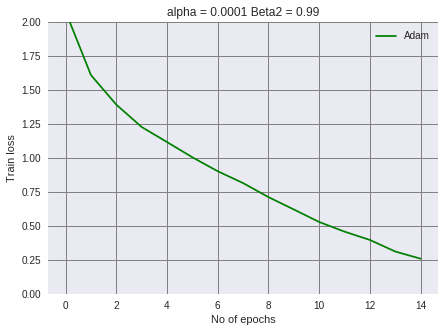

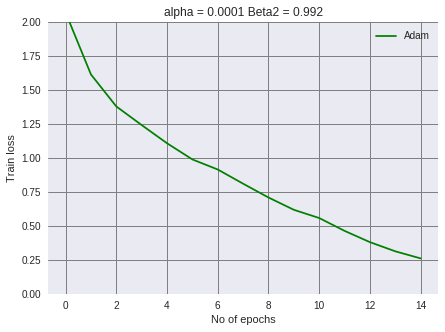

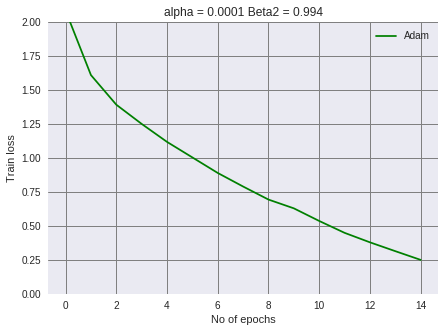

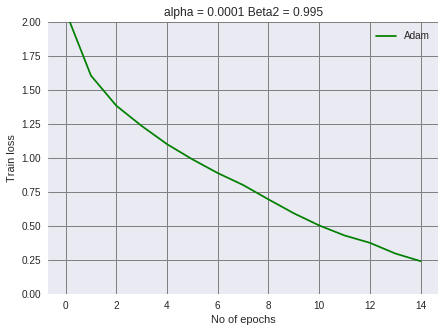

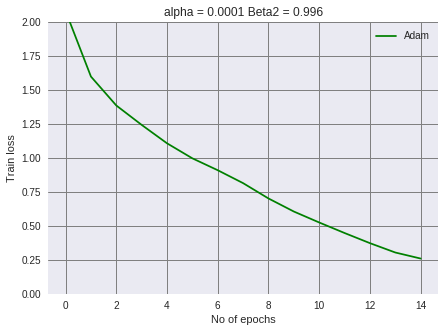

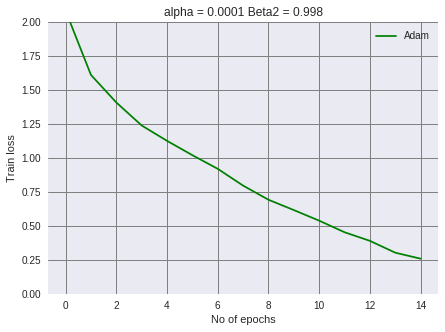

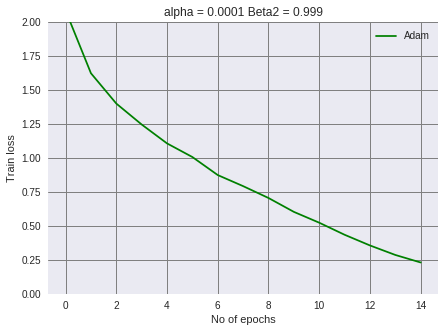

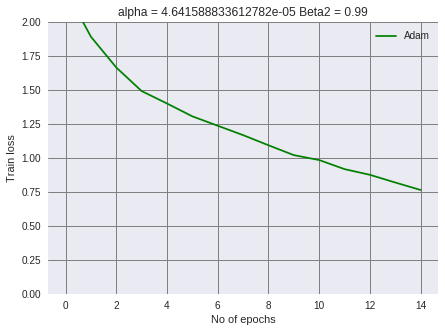

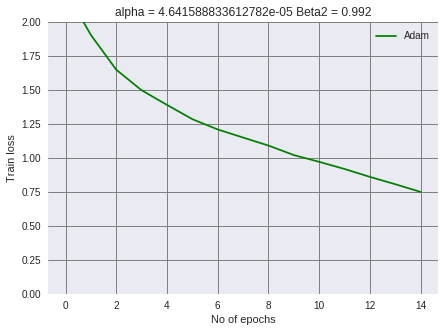

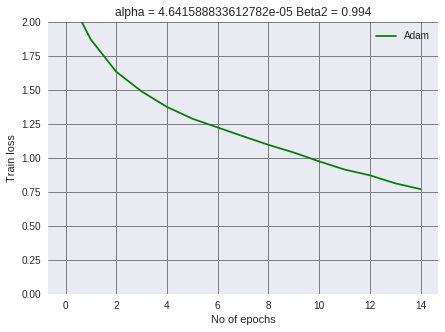

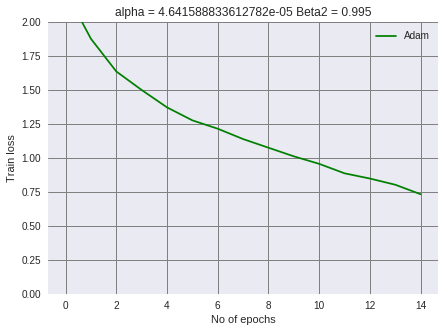

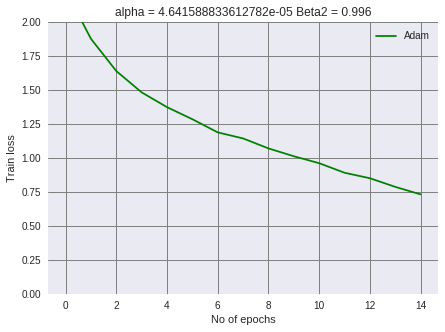

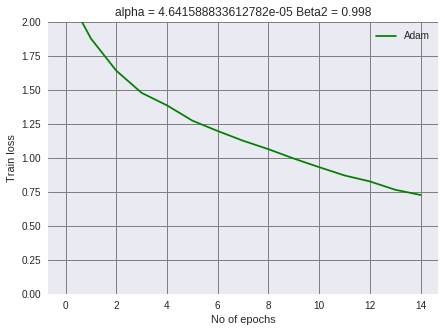

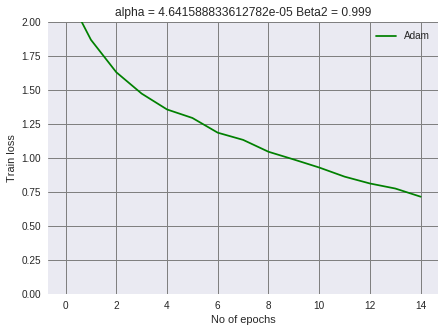

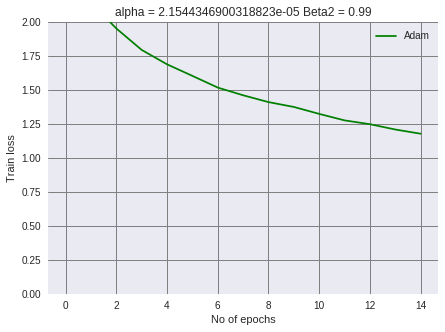

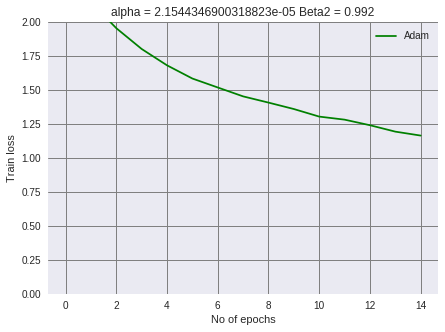

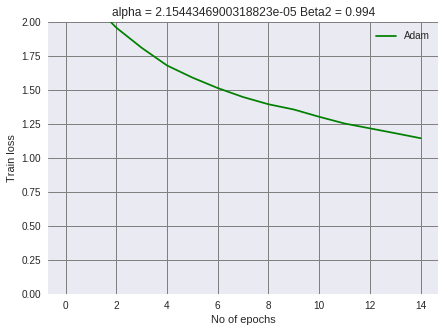

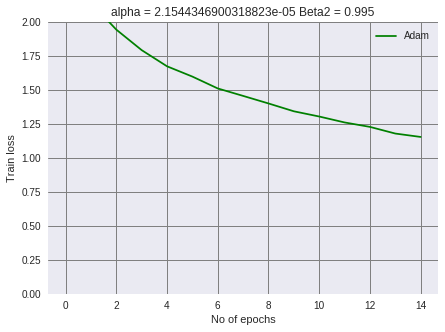

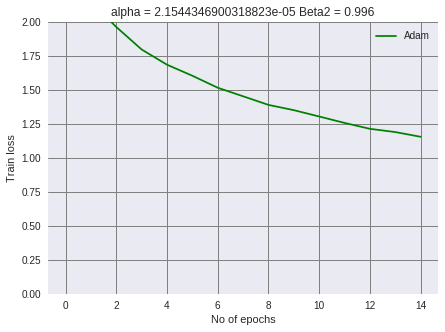

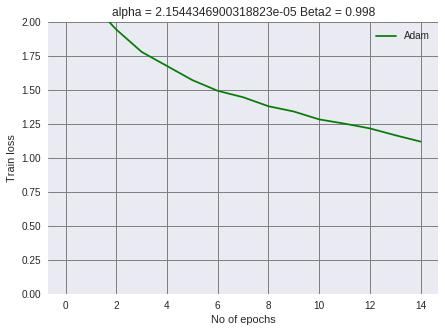

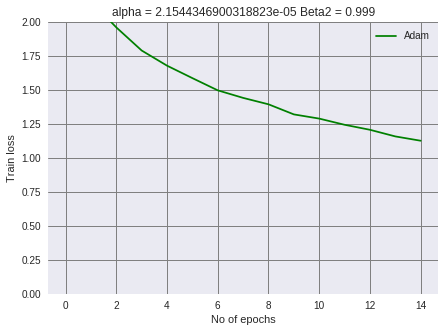

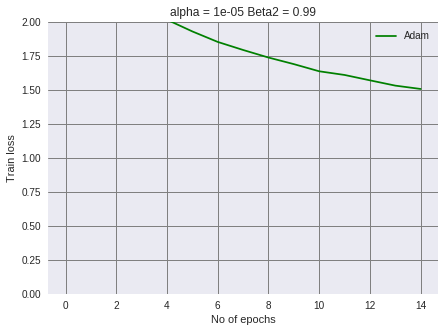

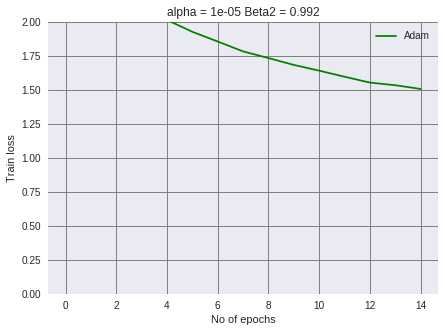

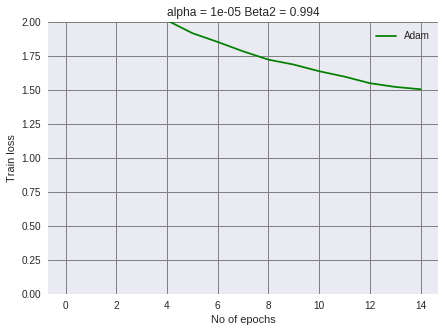

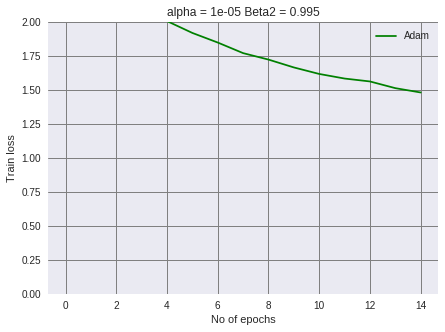

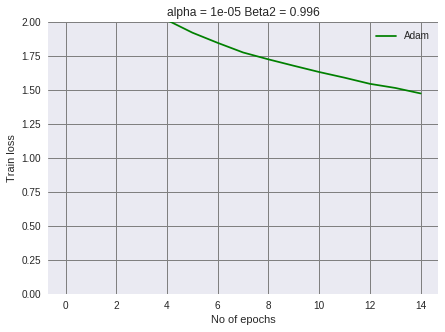

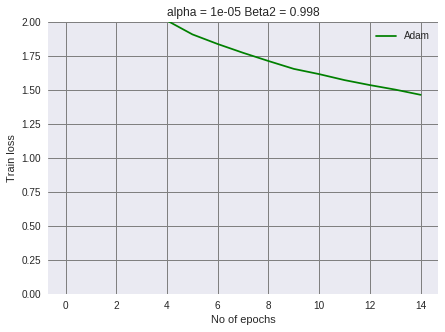

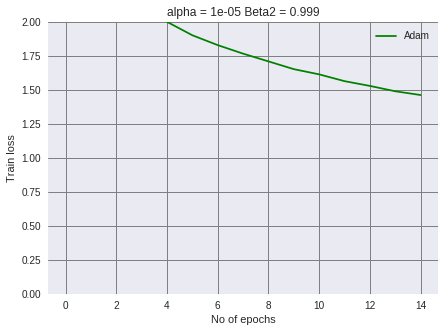

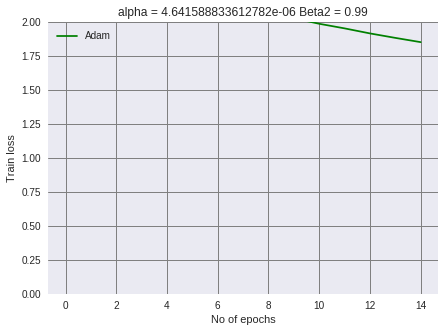

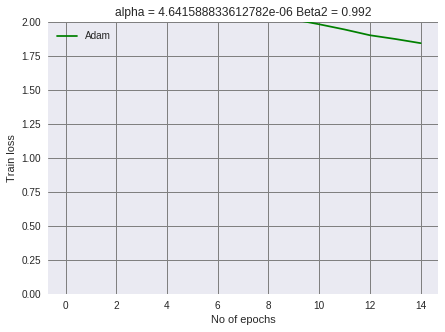

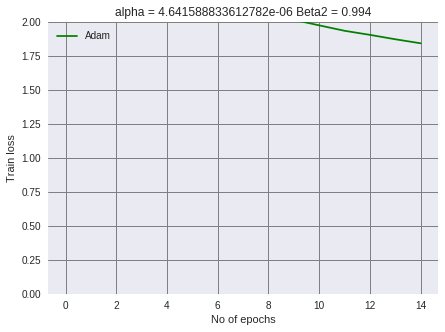

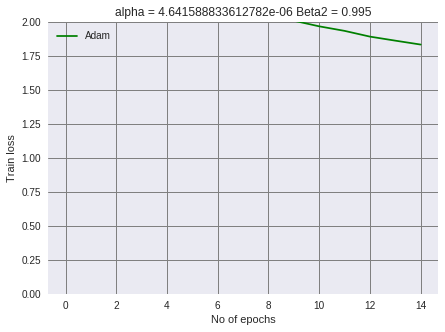

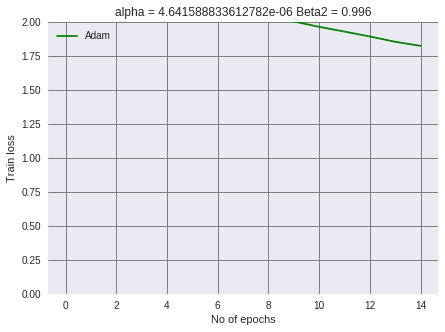

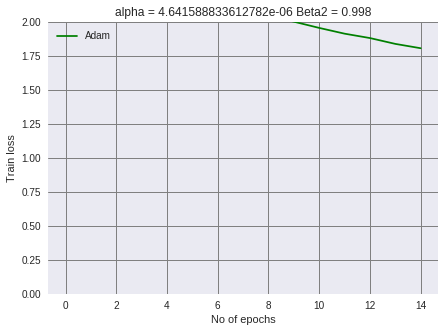

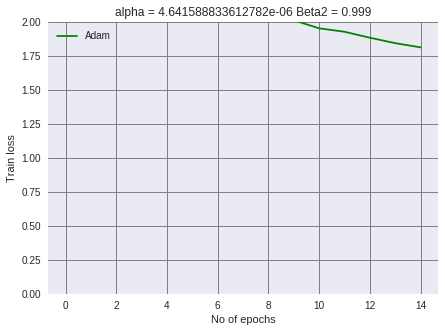

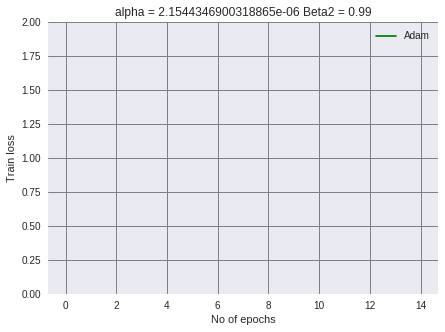

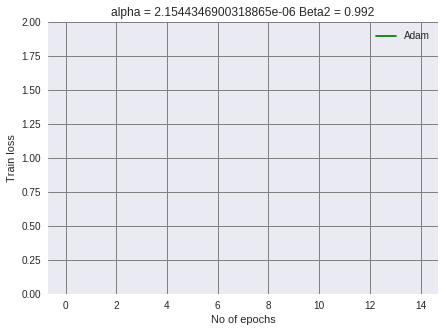

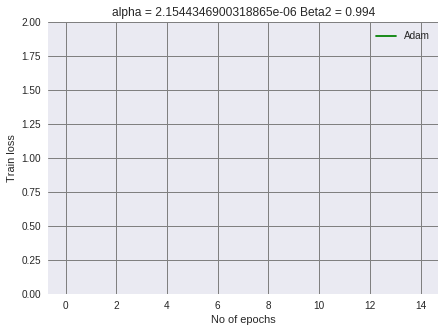

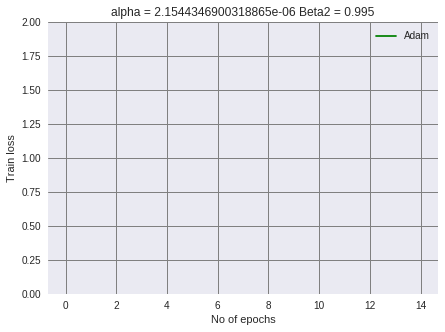

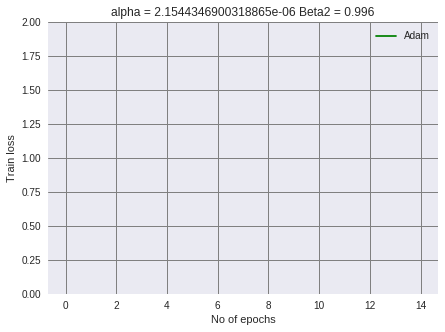

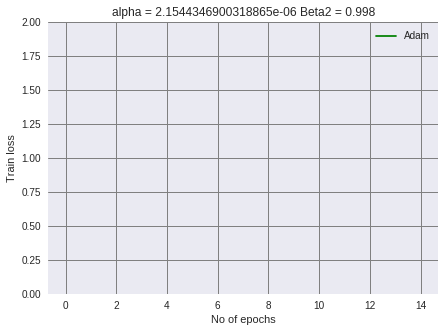

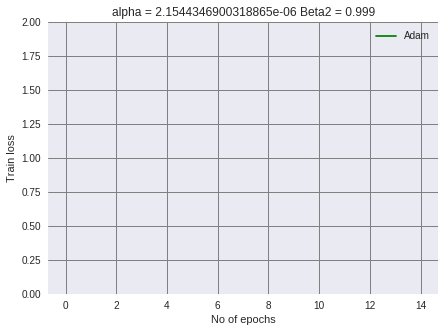

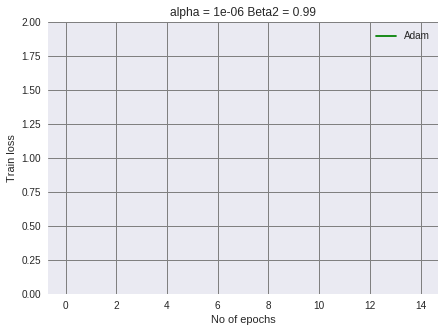

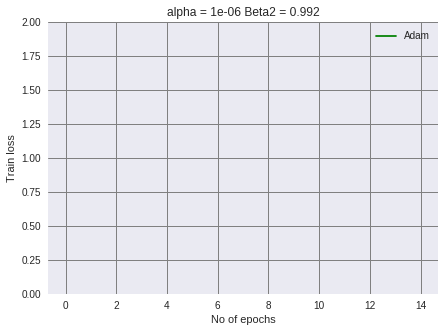

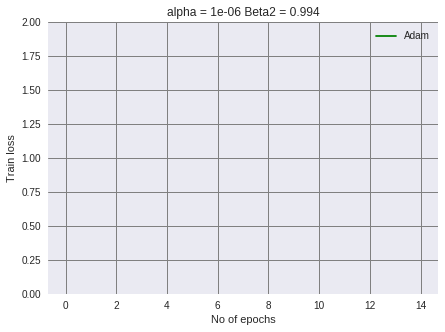

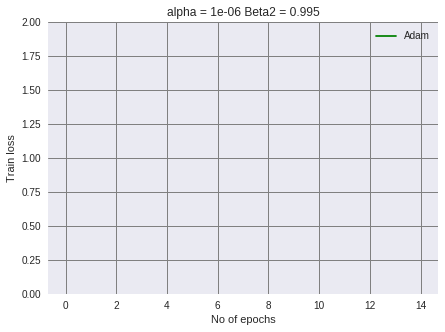

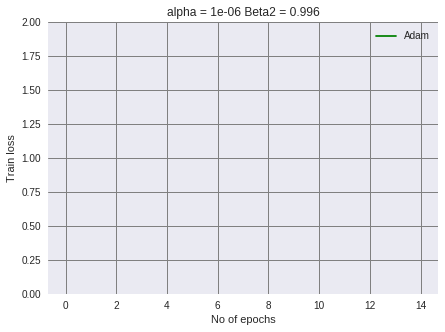

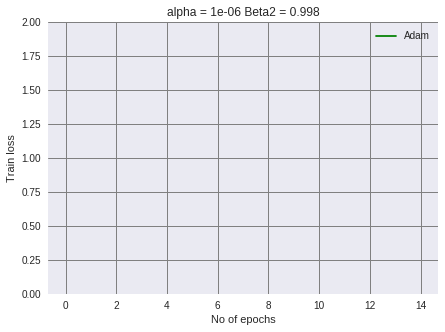

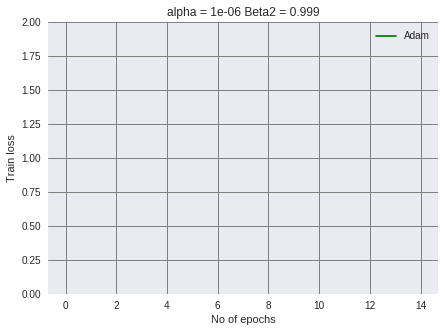

In [21]:
#Plotting train loss vs number of iterations graph for every hyper-parameter combination for Adam
x = np.arange(0,num_epochs)
print(x)
for i in range(len(train_loss_list_adam)):
  
  plt.figure(figsize=(7,5))
  title = "alpha = " + str(train_loss_list_adam[i][1]) + " Beta2 = " + str(train_loss_list_adam[i][2])
  plt.title(title)
  plt.plot(x, train_loss_list_adam[i][0], 'g', label="Adam")
  plt.ylim(0,2)
  plt.grid(color='gray', linewidth=1)
  plt.legend(loc='best')
  plt.xlabel('No of epochs')
  plt.ylabel('Train loss')
  plt.show()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


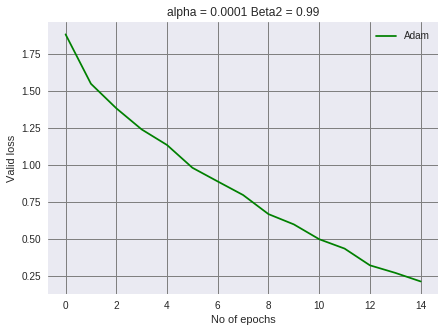

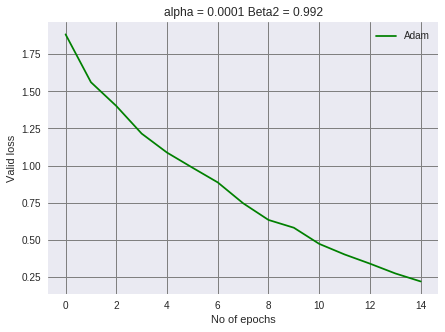

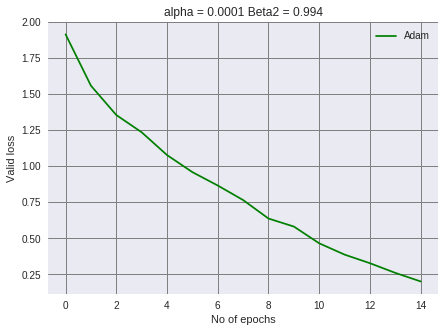

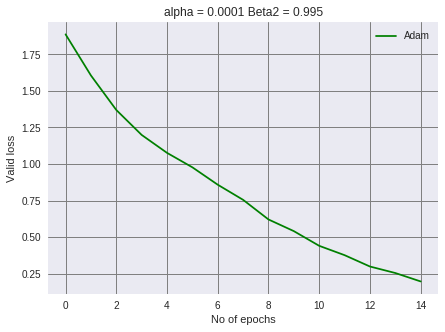

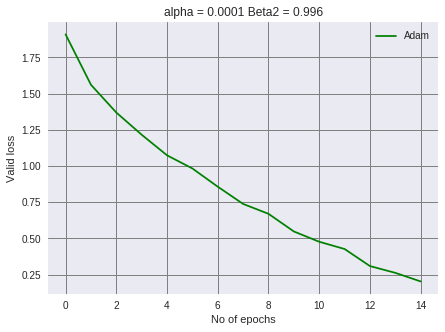

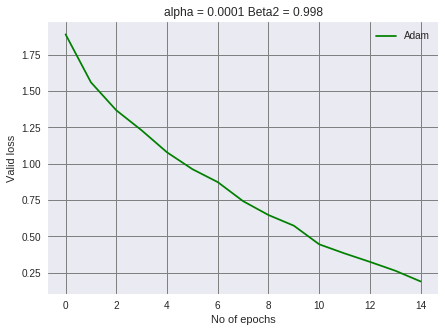

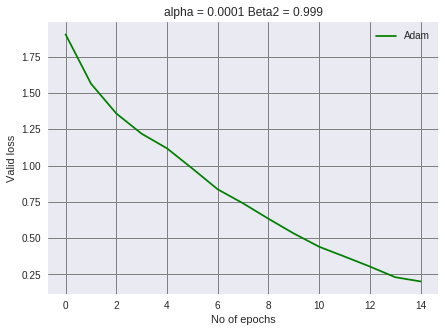

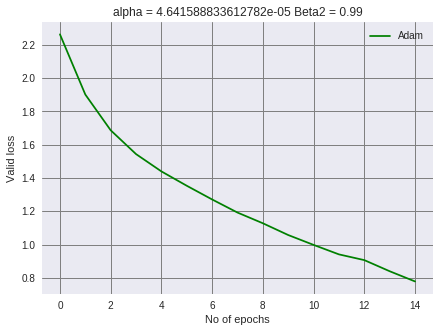

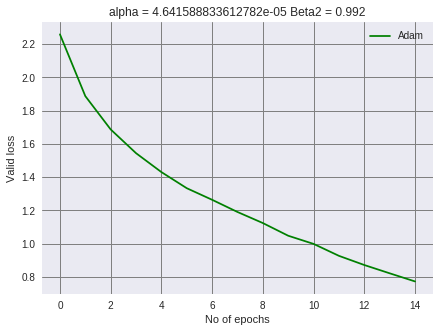

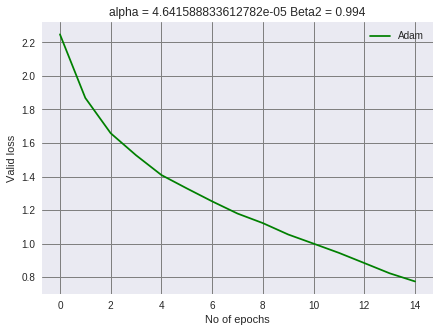

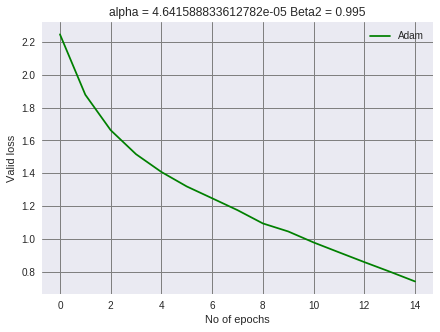

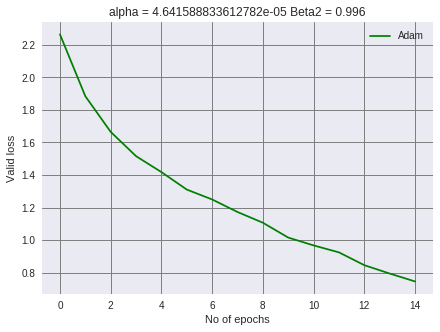

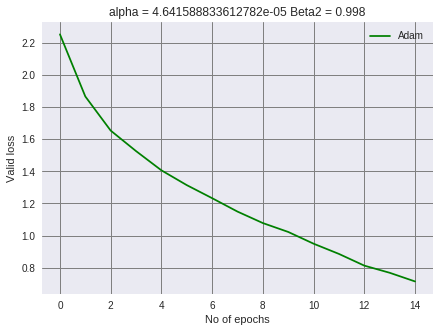

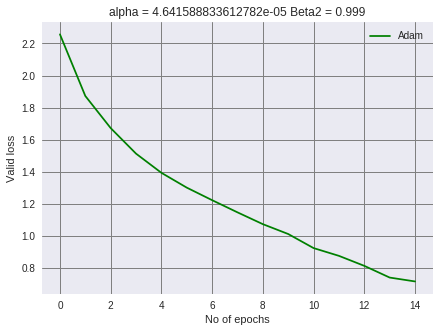

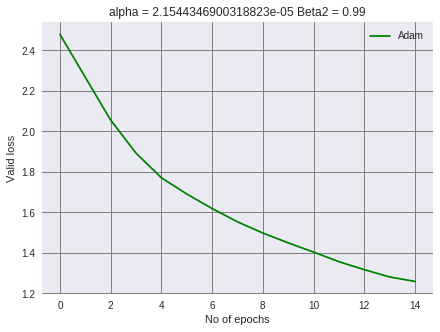

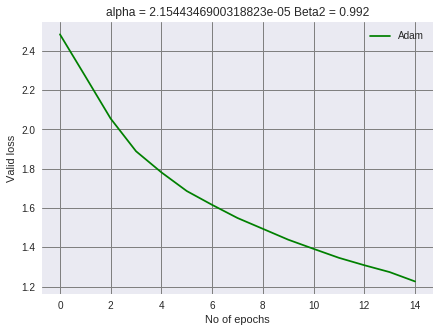

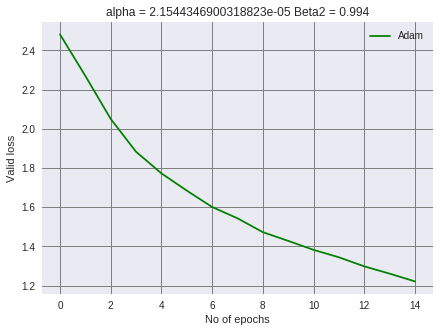

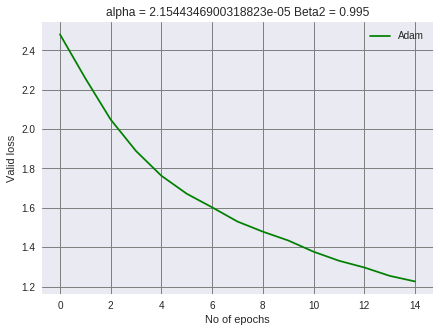

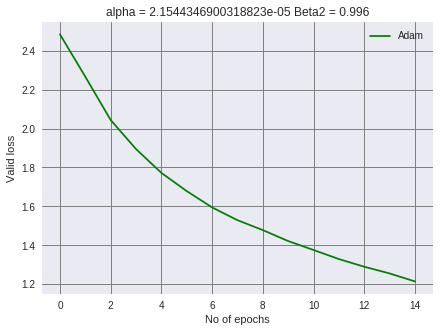

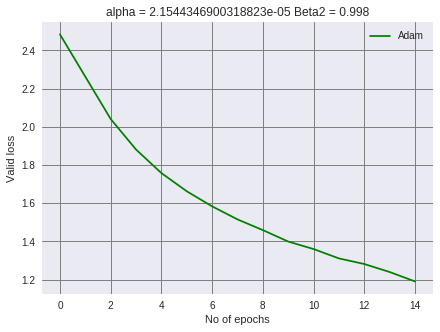

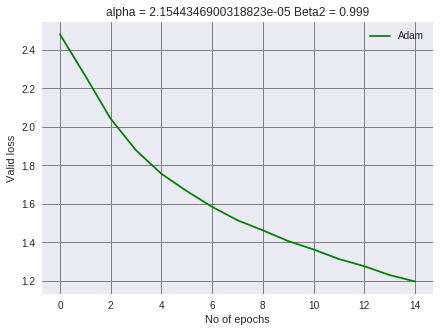

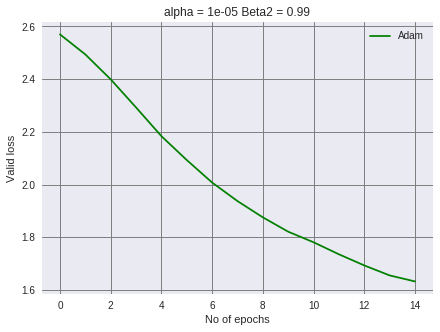

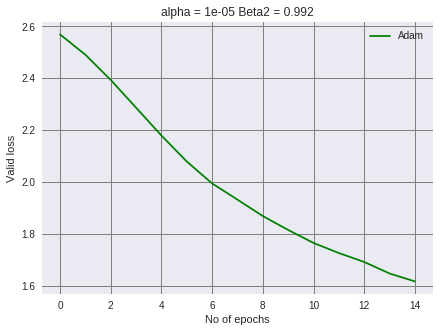

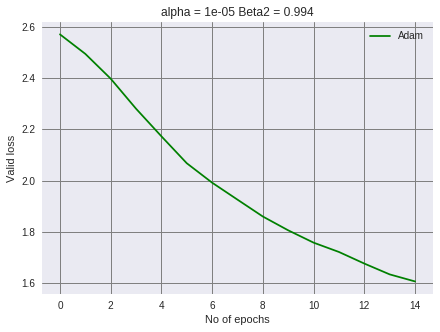

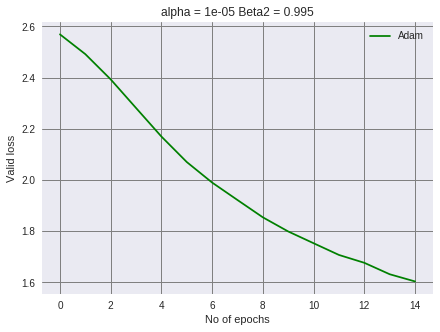

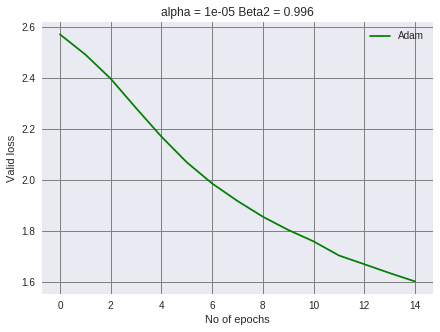

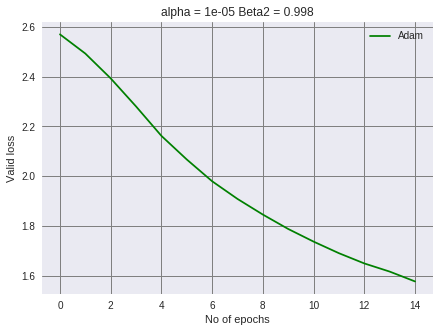

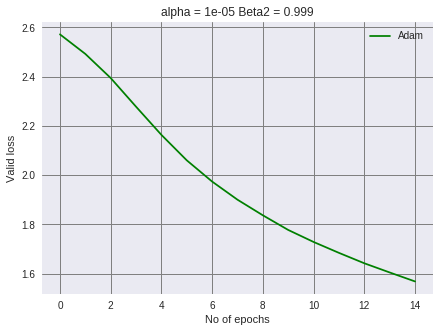

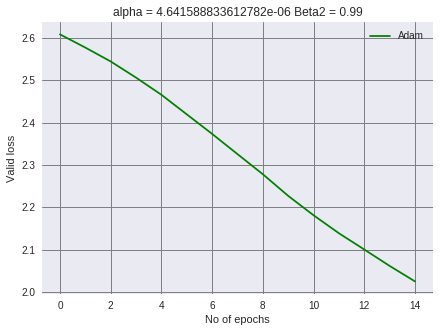

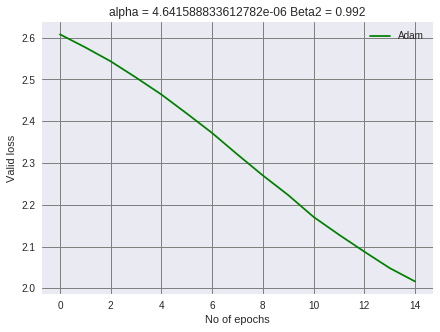

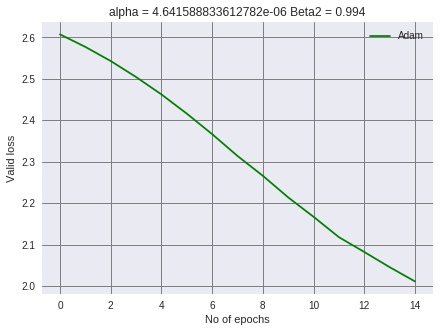

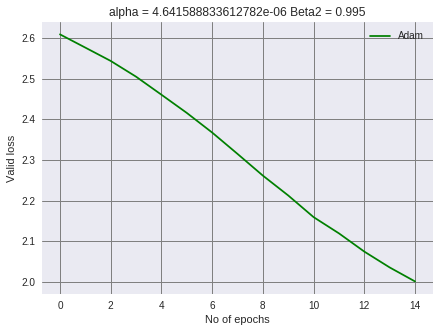

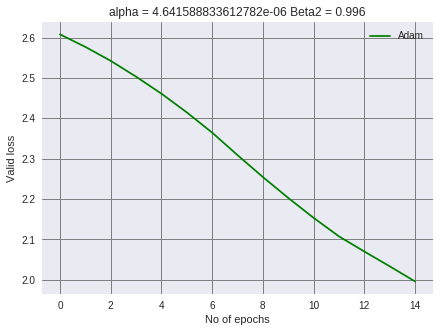

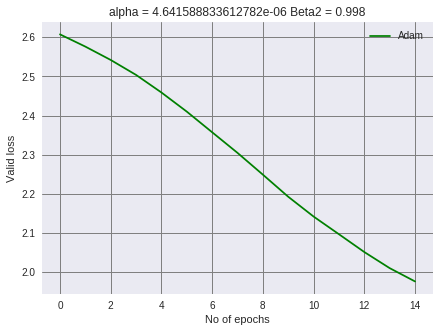

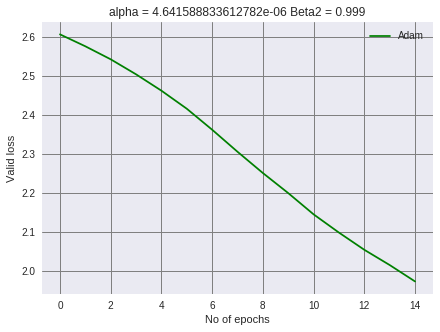

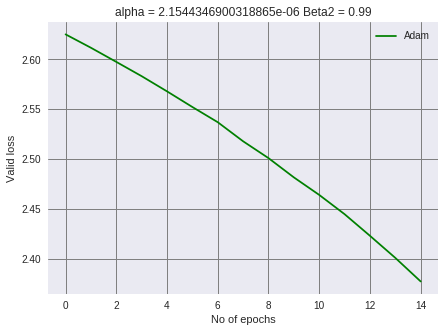

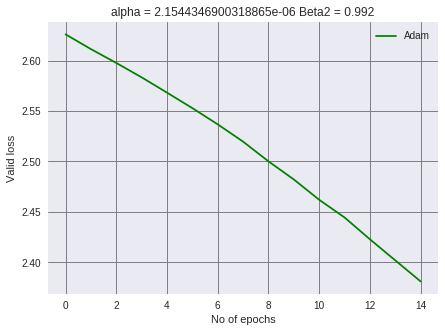

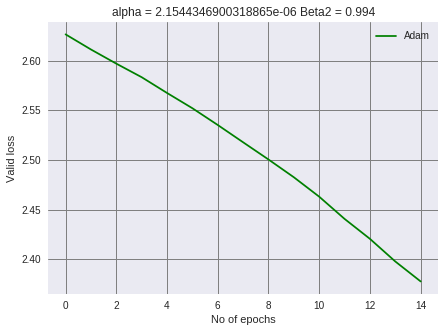

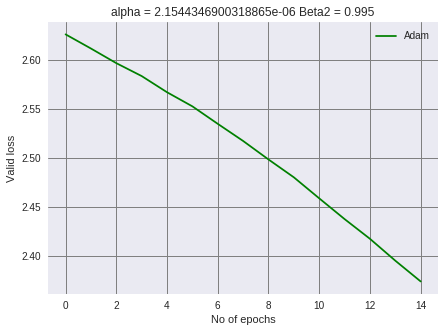

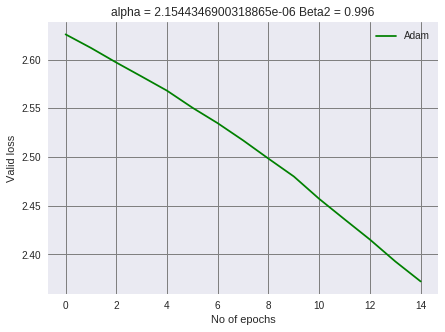

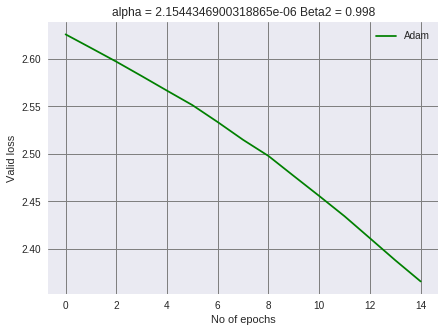

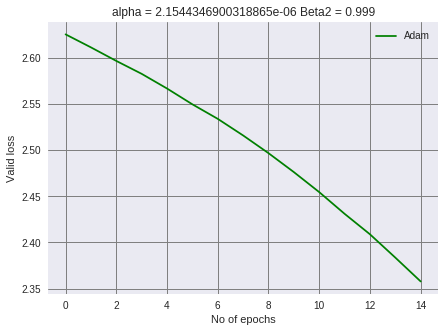

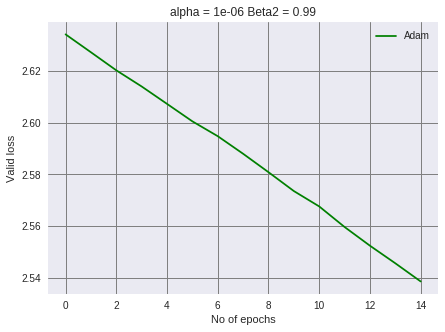

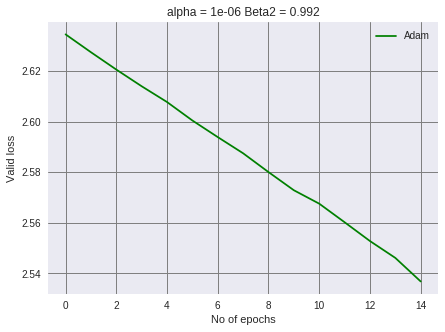

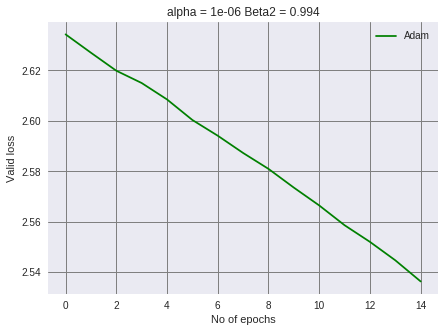

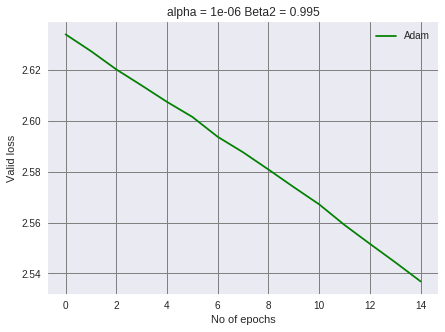

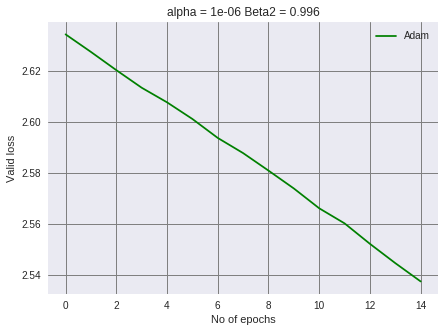

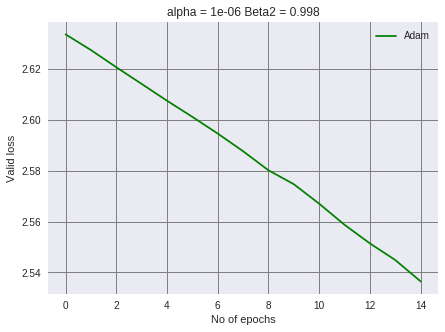

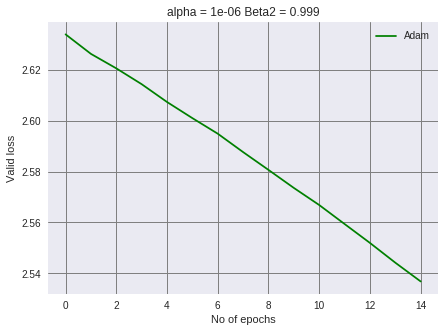

In [22]:
#Plotting validation loss vs number of iterations graph for every hyper-parameter combination for Adam
x = np.arange(0,num_epochs)
print(x)
for i in range(len(valid_loss_list_adam)):
  
  plt.figure(figsize=(7,5))
  title = "alpha = " + str(valid_loss_list_adam[i][1]) + " Beta2 = " + str(valid_loss_list_adam[i][2])
  plt.title(title)
  plt.plot(x, valid_loss_list_adam[i][0], 'g', label="Adam")
  plt.grid(color='gray', linewidth=1)
  plt.legend(loc='best')
  plt.xlabel('No of epochs')
  plt.ylabel('Valid loss')
  plt.show()

In [0]:
#Minimum validation loss was calculated for eachcombination  and  the  pair  which  resulted  in  least  validationloss with a non-increasing trajectory of validation loss withepochs was chosen as the best value for the hyper-parameters


min_valid_loss_adam = []
param_combo_count = 0   
for alpha_idx, alpha in enumerate(alphas):
  for beta_idx, beta in enumerate(betas):
    min_valid_for_alpha_beta = (min(valid_loss_list_adam[param_combo_count][0]))
    min_valid_loss_adam.append(min_valid_for_alpha_beta)
    param_combo_count += 1

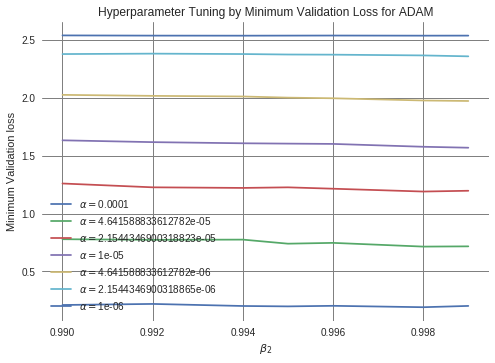

In [24]:
# Hyperparameter Tuning results by Minimum Validation Loss for ADAM
count = 0
title = "Hyperparameter Tuning by Minimum Validation Loss for ADAM"
plt.title(title)
for i , alpha in enumerate(alphas):
  plt.plot(betas, min_valid_loss_adam[count:count+len(betas)], label=r'$\alpha = $'+str(alpha))
  count += len(betas)
plt.gca().set_facecolor('w')
plt.grid(color='gray', linewidth=1)
plt.legend(loc='best')
#plt.ylim(0,2.7)
plt.xlabel(r'$\beta_2$')
plt.ylabel('Minimum Validation loss')
plt.show()

In [0]:
alpha_adam = 2.15443469e-05
beta2_adam = 0.998

In [0]:
net_adam.load_state_dict(initial_state)

In [0]:
# Learning the parameters using Amsgrad optimization with categorical cross-entropy loss. 
optimizer_adam = optim.Adam(net_adam.parameters(), lr=alpha_adam, betas=(0.9,beta2_adam))

In [41]:
#The code below runs for 25 epochs, learns the parameters of the model using Amsgrad optimizer with cross-entropy loss function 
#and propagates back the gradients in the network. It prints the train loss after every  epoch and validation loss after each epoch.
train_loss_list_epoch_adam = []
test_loss_list_epoch_adam = []
train_loss_list_iter_adam = []
pkl_filename = 'nn_saved_model_adam.pkl'
num_epochs = 70
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss_train = 0.0
    for i, data in enumerate(trainloader_cifar_10, 0):
        running_loss = 0.0
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        # zero the parameter gradients
        optimizer_adam.zero_grad()

        # forward + backward + optimize
        outputs = net_adam(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_adam.step()

        # print statistics
        running_loss_train += loss.data[0]
        running_loss = loss.data[0]
        train_loss_list_iter_adam.append(running_loss)
        
    train_loss = running_loss_train/num_batches_train
    test_loss = validation_loss(testloader_cifar_10, num_batches_test, net_adam,criterion)
    print ('Epoch: %d Train loss: %.3f' %(epoch + 1, train_loss))
    print ('Epoch: %d Test loss: %.3f' %(epoch + 1, test_loss))
    train_loss_list_epoch_adam.append(train_loss)
    test_loss_list_epoch_adam.append(test_loss)

    torch.save(net_adam.state_dict(), pkl_filename)

print('Finished Training')

Epoch: 1 Train loss: 1.745
Epoch: 1 Test loss: 1.429
Epoch: 2 Train loss: 1.308
Epoch: 2 Test loss: 1.250
Epoch: 3 Train loss: 1.159
Epoch: 3 Test loss: 1.150
Epoch: 4 Train loss: 1.056
Epoch: 4 Test loss: 1.079
Epoch: 5 Train loss: 0.980
Epoch: 5 Test loss: 1.031
Epoch: 6 Train loss: 0.921
Epoch: 6 Test loss: 0.997
Epoch: 7 Train loss: 0.872
Epoch: 7 Test loss: 0.971
Epoch: 8 Train loss: 0.827
Epoch: 8 Test loss: 0.953
Epoch: 9 Train loss: 0.788
Epoch: 9 Test loss: 0.928
Epoch: 10 Train loss: 0.752
Epoch: 10 Test loss: 0.916
Epoch: 11 Train loss: 0.718
Epoch: 11 Test loss: 0.900
Epoch: 12 Train loss: 0.686
Epoch: 12 Test loss: 0.900
Epoch: 13 Train loss: 0.653
Epoch: 13 Test loss: 0.895
Epoch: 14 Train loss: 0.624
Epoch: 14 Test loss: 0.890
Epoch: 15 Train loss: 0.596
Epoch: 15 Test loss: 0.888
Epoch: 16 Train loss: 0.567
Epoch: 16 Test loss: 0.884
Epoch: 17 Train loss: 0.539
Epoch: 17 Test loss: 0.892
Epoch: 18 Train loss: 0.513
Epoch: 18 Test loss: 0.894
Epoch: 19 Train loss: 0.488


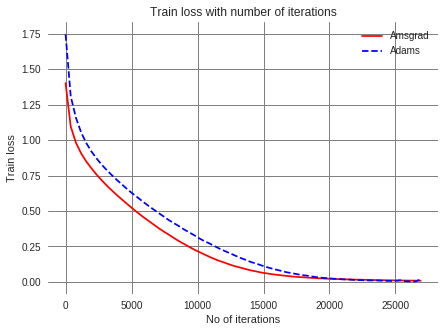

In [44]:
# Plotting the train loss with number of iterations for AMSGrad and Adam algorithm 
x = np.arange(0,num_epochs)
plt.figure(figsize=(7,5))
actual, = plt.plot(x*num_batches_train,train_loss_list_epoch, 'r-', label="Amsgrad")
predicted, = plt.plot(x*num_batches_train, train_loss_list_epoch_adam, 'b--', label ="Adams")
plt.gca().set_facecolor('w')
plt.grid(color='gray', linewidth=1)

plt.title("Train loss with number of iterations")
plt.legend(handles=[actual,predicted])
plt.xlabel('No of iterations')
plt.ylabel('Train loss')
plt.show()

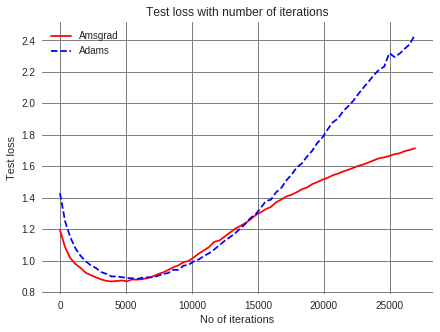

In [45]:
# Plotting the test loss with number of iterations for AMSGrad and Adam algorithm 
x = np.arange(0,num_epochs)

plt.figure(figsize=(7,5))
actual, = plt.plot(x*num_batches_train,test_loss_list_epoch, 'r-', label="Amsgrad")
predicted, = plt.plot(x*num_batches_train, test_loss_list_epoch_adam, 'b--', label ="Adams")
plt.gca().set_facecolor('w')
plt.grid(color='gray', linewidth=1)

plt.title("Test loss with number of iterations")
plt.legend(handles=[actual,predicted])
plt.xlabel('No of iterations')
plt.ylabel('Test loss')
plt.show()